### **Red Wine Quality Regression Analysis**

The dataset contains physicochemical features (input) of red wine variant of the Portuguese 'Vinho Verde' red wine. The sensory variable (wine quality) is the output. It is the perceived wine quality by human. <br>
**The goal** of this analysis is to identify which variables influence perceived wine quality the most by fitting an **explanatory** linear regression model.

This dataset is used from: P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

First, let's import all the tools we will use for the analysis.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import spearmanr
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.regressionplots import add_lowess
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.diagnostic import het_white, linear_reset
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.tools.tools import add_constant

In [5]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import os
import sys

sys.path.append(os.path.abspath(".."))
from utils import utils

In [6]:
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", 50)

In [7]:
sns.set_theme(style="whitegrid", palette="colorblind")
params = {
    "figure.titlesize": 12,
    "figure.titleweight": "bold",
    "axes.titlelocation": "left",
    "axes.titleweight": "bold",
    "axes.titlesize": 11,
    "axes.labelsize": 9,
    "axes.titlecolor": "#343030",
    "axes.labelcolor": "#343030",
    "yaxis.labellocation": "top",
    "xaxis.labellocation": "left",
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "xtick.major.size": 0,
    "ytick.major.size": 0,
    "legend.title_fontsize": 9,
    "legend.fontsize": 9,
    "legend.frameon": False,
    "legend.loc": "upper left",
    "grid.alpha": 0.4,
    "axes.grid": True,
    "axes.grid.axis": "both",
    "axes.spines.right": False,
    "axes.spines.top": False,
}
plt.rcParams.update(params)

#### **1. Explanatory Data Analysis**

##### **1.1. Initial Overview of the Dataset**

First we will import dataset and get on overview of its features.

In [11]:
df = pd.read_csv("../data/winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In the "Modeling wine preferences by data mining from physicochemical properties" by P. Cortez, A. Cerdeira, Fernando Almeida, Telmo Matos, J. Reis. 2009 it is written that there are "1599 red wine samples". 

"The data were collected from May/2004 to February/2007 using only protected designation of origin samples that were tested at the official certification entity (CVRVV). The CVRVV is an inter-professional organization with the goal of improving the quality and marketing of vinho verde. The data were recorded by a computerized system (iLab), which automatically manages the process of wine sample testing from producer requests to laboratory and sensory analysis. Each entry denotes a given test (analytical or sensory) [...] 

Regarding the preferences, each sample was evaluated by a minimum of three sensory assessors (using blind tastes), which graded the wine in a scale that ranges
from 0 (very bad) to 10 (excellent). The final sensory score is given by the median of these evaluations."

In [13]:
utils.get_general_df_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
Dataset has 1599 rows and 12 features.
Amount of missing values in the features are: 
{'fixed acidity': 0, 'volatile acidity':

From our dataset overview we see that there are 240 duplicated samples. But, as we got to know from the fragment of the original analysis, all 1599 wine samples are unique. So there are only wines with the same physicochemical characteristics which seems to be duplicate.

Let's check how data is distributed by wine quality class.

In [15]:
df.quality.value_counts(normalize=True).map(lambda x: f"{x * 100:.2f}%")

quality
5    42.59%
6    39.90%
7    12.45%
4     3.31%
8     1.13%
3     0.63%
Name: proportion, dtype: object

We see that 5 and 6 quality level classes are dominant in our dataset. Poor quality (3, 4 classes) and 8 (good quality) comprise minority of the samples. So our dataset is imbalanced for the response distribution perspective.

Now we will separate predictors (X) from response variable (y) and get to know more about predictors.

In [18]:
features = df.columns.to_numpy()
X = df.loc[:, features[:-1]]
y = df.loc[:, ["quality"]]
X.shape

(1599, 11)

For Portuguese red wine, there are typical ranges for physicochemical features, with values outside these ranges potentially indicating anomalies. Here's a breakdown of the common ranges and potential anomaly thresholds based on published studies of Portuguese red wines (particularly Vinho Verde): <br>

*Typical Ranges and Anomaly Thresholds*:

* **Fixed Acidity (g/L tartaric acid)**  
    Normal range: 4.6 - 15.9   
    Potential anomalies: < 4.0 or > 16.0

* **Volatile Acidity (g/L acetic acid)**   
    Normal range: 0.1 - 1.4    
    Potential anomalies: > 1.4 (becomes unpleasant above this level)

* **Citric Acid (g/L)**   
    Normal range: 0.0 - 1.0    
    Potential anomalies: > 1.0

* **Residual Sugar (g/L)**    
    Normal range for dry red wine: 0.9 - 15.5    
    Potential anomalies: > 20.0 (unusual for red Portuguese wines)

* **Chlorides (g/L sodium chloride)**    
    Normal range: 0.01 - 0.61    
    Potential anomalies: > 0.6    

* **Free Sulfur Dioxide (mg/L)**    
    Normal range: 1 - 72    
    Potential anomalies: > 70 (can affect taste)    

* **Total Sulfur Dioxide (mg/L)**     
    Normal range: 6 - 289   
    Potential anomalies: > 280 (legal limits are higher, but quality is often affected)

* **Density (g/cm³)**    
    Normal range: 0.990 - 1.004   
    Potential anomalies: < 0.990 or > 1.005    

* **pH**   
    Normal range: 2.74 - 4.01   
    Potential anomalies: < 2.7 or > 4.0    

* **Sulphates (g/L potassium sulphate)**   
    Normal range: 0.33 - 2.0     
    Potential anomalies: > 2.0

* **Alcohol (% vol)**    
    Normal range: 8.4 - 14.9       
    Potential anomalies: < 8.0 or > 15.0   

However, some "anomalous" values might actually represent special characteristics of certain wines rather than errors.

Below, we will make predictor summary statistics table with anomalous ranges for each.

In [20]:
summary_df = df.describe().map(lambda x: f"{x:.2f}")
summary_df.loc["anomaly"] = {
    "fixed acidity": "< 4.0 or > 16.0",
    "volatile acidity": "> 1.4",
    "citric acid": "> 1.0",
    "residual sugar": "> 20.0",
    "chlorides": "> 0.6",
    "free sulfur dioxide": "> 70",
    "total sulfur dioxide": "> 280",
    "density": "< 0.990 or > 1.005",
    "pH": "< 2.7 or > 4.0",
    "sulphates": "> 2.0",
    "alcohol": "< 8.0 or > 15.0",
    "quality": "-",
}
summary_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00
mean,8.32,0.53,0.27,2.54,0.09,15.87,46.47,1.00,3.31,0.66,10.42,5.64
std,1.74,0.18,0.19,1.41,0.05,10.46,32.90,0.00,0.15,0.17,1.07,0.81
min,4.60,0.12,0.00,0.90,0.01,1.00,6.00,0.99,2.74,0.33,8.40,3.00
25%,7.10,0.39,0.09,1.90,0.07,7.00,22.00,1.00,3.21,0.55,9.50,5.00
50%,7.90,0.52,0.26,2.20,0.08,14.00,38.00,1.00,3.31,0.62,10.20,6.00
75%,9.20,0.64,0.42,2.60,0.09,21.00,62.00,1.00,3.40,0.73,11.10,6.00
max,15.90,1.58,1.00,15.50,0.61,72.00,289.00,1.00,4.01,2.00,14.90,8.00
anomaly,< 4.0 or > 16.0,> 1.4,> 1.0,> 20.0,> 0.6,> 70,> 280,< 0.990 or > 1.005,< 2.7 or > 4.0,> 2.0,< 8.0 or > 15.0,-


Below we will examine wine samples, which have predictor values exceeding anomaly limit.

The first one is volatile acidity. However, for late harvest red wines volatile acidity can be up to 1.7 g/l. We see that quite high volatile acidity potentially negatively impact wine quality (the 3rd quality level of the wine with maximum volatile acidity).

In [22]:
df.query("`volatile acidity` > 1.4")

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1299,7.6,1.58,0.0,2.1,0.137,5.0,9.0,0.99476,3.5,0.4,10.9,3


Next is free and total sulfur dioxide.

For red wines with sugar > 5 g/l limits for total sulfur dioxide are even higher: total sulfur dioxide - about 300 mg/l. These limits are specified by the International Code of Oenological Practices (OIV Code Sheet, Issue 2015/01, XXXVII. ANNEX: MAXIMUM ACCEPTABLE LIMITS). 

Free sulfur dioxide is the active portion of total sulfur dioxide that protects against microbes and oxidation. Total sulfur dioxide includes both free and bound forms. Wines with higher residual sugar are allowed to have higher sulfur dioxide levels because sugar can bind with sulfur dioxide, reducing its free form.    

We can observe that wines with higher sulfur dioxide really have higher residual sugar concentration.

In [24]:
df.query("`free sulfur dioxide` > 70")

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1244,5.9,0.29,0.25,13.4,0.067,72.0,160.0,0.99721,3.33,0.54,10.3,6


In [25]:
df.query("`total sulfur dioxide` > 280")

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1081,7.9,0.3,0.68,8.3,0.05,37.5,289.0,0.99316,3.01,0.51,12.3,7


**Key Insights**:
* We have checked lower and upper limits of physicochemical features and can conclude that they are within acceptable boundaries. 
* We haven't detected any anomalous perdictors' values. 

##### **1.2. Splitting the Data**

To train our linear regression model, we will split dataset into train and test subsets. 80% of the dataset we will use to train the model and the remaining 20% we will use later to test the model robustness.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1, stratify=y
)
df_train = pd.concat([X_train, y_train], axis=1)
df_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
952,8.2,0.310,0.40,2.2,0.058,6.0,10.0,0.99536,3.31,0.68,11.2,7
563,7.6,0.290,0.49,2.7,0.092,25.0,60.0,0.99710,3.31,0.61,10.1,6
150,7.3,0.330,0.47,2.1,0.077,5.0,11.0,0.99580,3.33,0.53,10.3,6
202,6.8,0.500,0.11,1.5,0.075,16.0,49.0,0.99545,3.36,0.79,9.5,5
638,7.7,0.915,0.12,2.2,0.143,7.0,23.0,0.99640,3.35,0.65,10.2,7


Now we will analyze more in a detail our training subset.

In [31]:
utils.get_general_df_info(df_train)

<class 'pandas.core.frame.DataFrame'>
Index: 1279 entries, 952 to 304
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1279 non-null   float64
 1   volatile acidity      1279 non-null   float64
 2   citric acid           1279 non-null   float64
 3   residual sugar        1279 non-null   float64
 4   chlorides             1279 non-null   float64
 5   free sulfur dioxide   1279 non-null   float64
 6   total sulfur dioxide  1279 non-null   float64
 7   density               1279 non-null   float64
 8   pH                    1279 non-null   float64
 9   sulphates             1279 non-null   float64
 10  alcohol               1279 non-null   float64
 11  quality               1279 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 129.9 KB
Dataset has 1279 rows and 12 features.
Amount of missing values in the features are: 
{'fixed acidity': 0, 'volatile acidity': 0, 

We see that in our training subset we have 156 duplicate samples, but as mentioned before, these are unique samples just with the same characteristics.

Let's examine summary statistics of predictors in our training dataset.

In [34]:
summary_df_train = df_train.describe().map(lambda x: f"{x:.2f}")
summary_df_train.loc["anomaly"] = {
    "fixed acidity": "< 4.0 or > 16.0",
    "volatile acidity": "> 1.4",
    "citric acid": "> 1.0",
    "residual sugar": "> 20.0",
    "chlorides": "> 0.6",
    "free sulfur dioxide": "> 70",
    "total sulfur dioxide": "> 280",
    "density": "< 0.990 or > 1.005",
    "pH": "< 2.7 or > 4.0",
    "sulphates": "> 2.0",
    "alcohol": "< 8.0 or > 15.0",
    "quality": "-",
}
summary_df_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00
mean,8.35,0.53,0.27,2.54,0.09,15.75,46.76,1.00,3.31,0.66,10.42,5.64
std,1.74,0.18,0.19,1.42,0.04,10.29,33.52,0.00,0.15,0.16,1.08,0.81
min,4.60,0.12,0.00,0.90,0.01,1.00,6.00,0.99,2.86,0.33,8.40,3.00
25%,7.20,0.39,0.10,1.90,0.07,7.00,22.00,1.00,3.20,0.55,9.50,5.00
50%,7.90,0.52,0.26,2.20,0.08,13.00,38.00,1.00,3.30,0.62,10.10,6.00
75%,9.20,0.64,0.43,2.60,0.09,21.00,63.00,1.00,3.40,0.73,11.10,6.00
max,15.90,1.33,0.79,15.50,0.47,72.00,289.00,1.00,4.01,1.98,14.90,8.00
anomaly,< 4.0 or > 16.0,> 1.4,> 1.0,> 20.0,> 0.6,> 70,> 280,< 0.990 or > 1.005,< 2.7 or > 4.0,> 2.0,< 8.0 or > 15.0,-


Here we see that into our training set we got our extreme values for predictors like, fixed acidity, free sulfur dioxide, total sulfur dioxide, pH, and alcohol. Average quality score for our training subset is 5.6 or median 6 points.

##### **1.3. Exploring Training Subset**

Now let's dive deeper in analyzing our training dataset to better understand our predictor variables and how they could potentially influence perceived wine quality.

* Fixed acidity - a good balance of fixed acidity gives wine a lively, bright taste. Too much = overly tart. Too little = flat or dull. Fixed acidity contributes to the wine’s crispness, freshness, and stability. It’s called “fixed” because it doesn’t evaporate easily. It includes non-volatile acids like tartaric, malic, and citric acid.

* Volatile acidity - a small amount is normal and adds complexity. But high levels usually indicate spoilage or poor winemaking.

* Citric acid - a type of fixed acid, but it's measured separately in wine analysis. It's found naturally in small amounts or added to adjust acidity. Too much can make a wine taste artificial or overly sour. 

Further, we will investigate distribution of those acidity features.

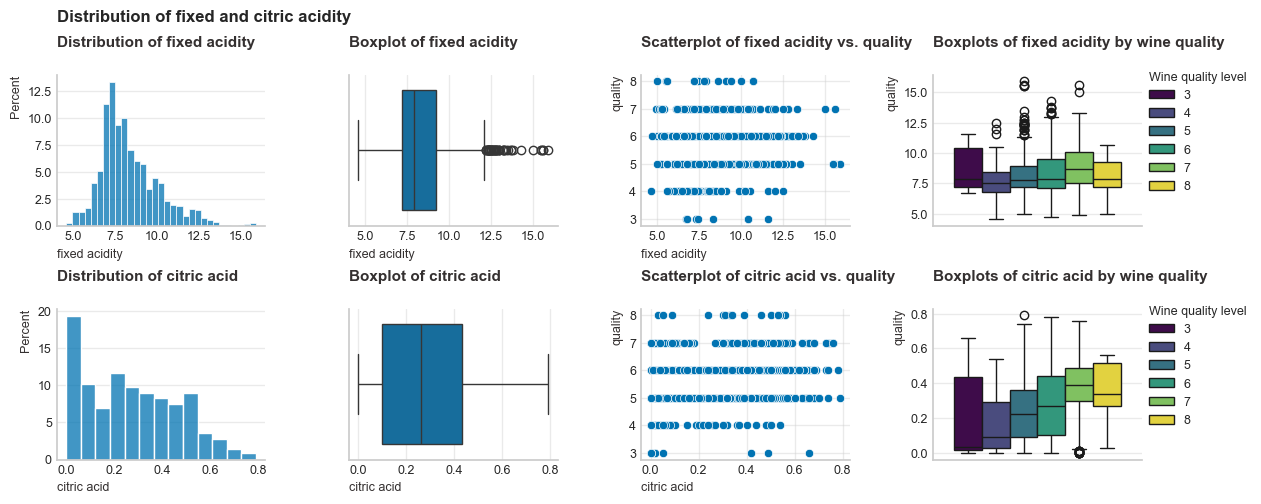

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1279.00,8.35,1.74,4.60,7.20,7.90,9.20,15.90
citric acid,1279.00,0.27,0.19,0.00,0.10,0.26,0.43,0.79


In [357]:
utils.plot_numerical_feature_distribution(
    df_train,
    (14, 5),
    ["fixed acidity", "citric acid"],
    "quality",
    0.23,
    1.01,
    0.4,
    0.55,
    "Distribution of fixed and citric acidity",
)

Fixed acidity is the umbrella for citric acid and other non-volatile acids. However, citric acid, being part of fixed acidity, may be considered separately because it can be added manually. We see from the rightmost boxplots that while the median fixed acidity seems to be similar to all the levels of red wine quality, citric acid differs across different quality levels - as median citric acid increases, quality levels seems to increase assuming positive association between quality and citric acid.    

Distributions of both predictors is positively skewed. Fixed acidity seems to have outliers mostly for the 5th and 6th quality classes.

Below let's look more closely at citric acid effect on wine quality.

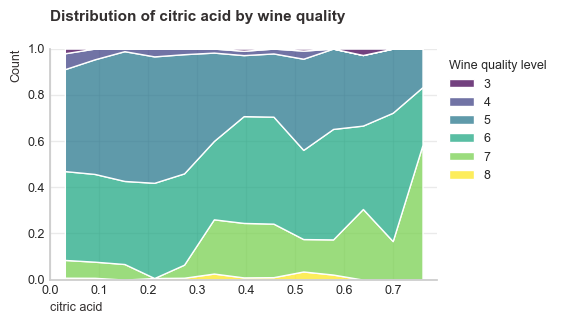

In [42]:
utils.make_polyplot(
    df_train,
    "citric acid",
    "quality",
    (5, 3),
    "Distribution of citric acid by wine quality",
    "Wine quality level",
    (1, 1),
    multiple="fill",
)

From the plot above we see that it could seem like higher wine quality is related with higher citric acid values.

So we can formulate our first hypothesis regarding our observation:
$$
\begin{equation*}
\begin{array}{l}
H_01: \text{Citric acid of wine has either no effect or a negative impact on perceived wine quality} \\
H_A1: \text{Citric acid of wine has a positive impact on perceived wine quality} \\
\alpha = 0.05
\end{array}
\end{equation*}
$$

Next we will analyze volatile acidity.

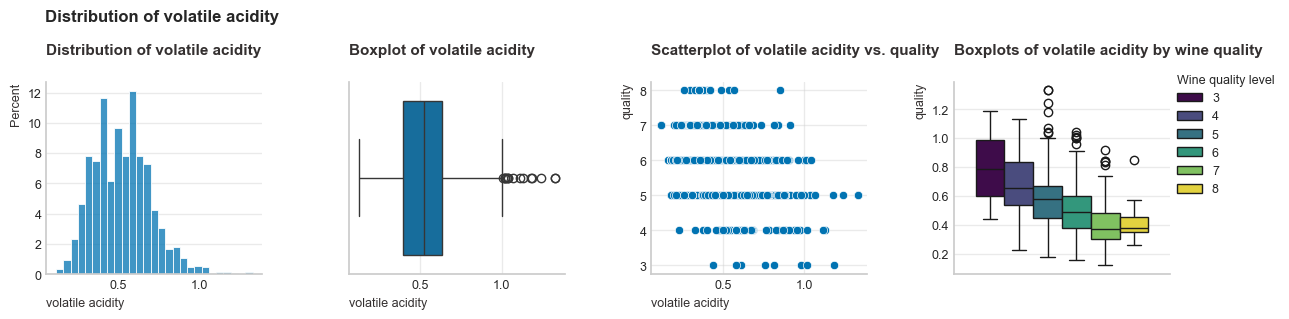

,count,mean,std,min,25%,50%,75%,max
volatile acidity,1279.00,0.53,0.18,0.12,0.39,0.52,0.64,1.33


In [45]:
utils.plot_numerical_feature_distribution(
    df_train,
    (14.5, 2.5),
    ["volatile acidity"],
    "quality",
    0.205,
    1.17,
    0.4,
    0.4,
    "Distribution of volatile acidity",
)

Volatile acidity (mostly acetic acid) spoils flavors at higher levels, indicating microbial spoilage or oxidation. Moderate levels may be tolerated. As from the boxplot in the right we see that as median volatile acidity decrease red wine quality increase. From the scatterplot we see that wines with the lowest variance in volatile acidity are perceived of higher quality. 

Distribution of volatile acidity seems roughly normal. Outliers mostly present in the 5-7th quality classes.

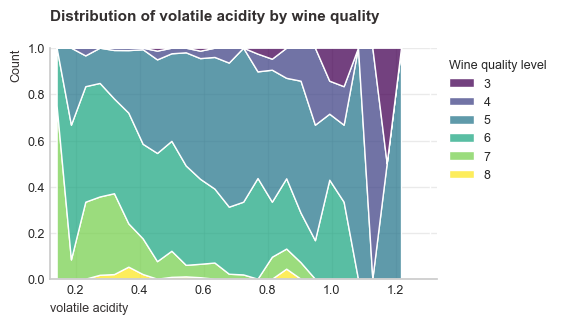

In [47]:
utils.make_polyplot(
    df_train,
    "volatile acidity",
    "quality",
    (5, 3),
    "Distribution of volatile acidity by wine quality",
    "Wine quality level",
    (1, 1),
    multiple="fill",
)

From the plot above we can notice that only wines belonging to lower quality classes (3-5) have the highest volatile acidity concentration.

So we can formulate the second hypothesis regarding our observation:
$$
\begin{equation*}
\begin{array}{l}
H_02: \text{Volatile acidity of wine has a positive or no impact on perceived wine quality} \\
H_A2: \text{Volatile acidity of wine has a negative impact on perceived wine quality} \\
\alpha = 0.05
\end{array}
\end{equation*}
$$

Further, we will explore residual sugar, density and alcohol since they are quite related.   

* Residual Sugar - the sugar left over in the wine after fermentation. Indicates sweetness — dry wines have low residual sugar; sweet wines have more. Moderation is key — quality doesn’t necessarily increase with sugar unless it’s a sweet wine style. 

* Density - mass per volume of wine; influenced by sugar, alcohol, and other solutes. Higher sugar = higher density; alcohol lowers density.

* Alcohol - ethanol content — result of fermentation. Higher alcohol can enhance aroma but overpower if too high.  

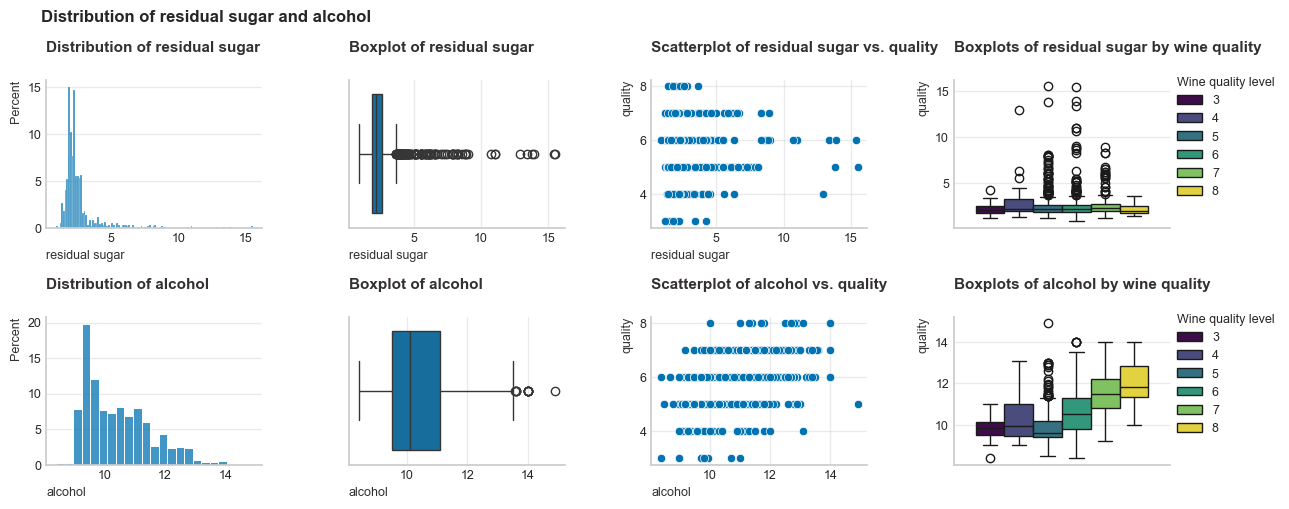

,count,mean,std,min,25%,50%,75%,max
residual sugar,1279.00,2.54,1.42,0.90,1.90,2.20,2.60,15.50
alcohol,1279.00,10.42,1.08,8.40,9.50,10.10,11.10,14.90


In [50]:
utils.plot_numerical_feature_distribution(
    df_train,
    (14.5, 5),
    ["residual sugar", "alcohol"],
    "quality",
    0.235,
    1.02,
    0.4,
    0.6,
    "Distribution of residual sugar and alcohol",
)

We see that residual sugar has positively skewed distribution and outliers are most prevalent in perceived lower wine quality classes (5-7 classes). Though median residual sugar is similar to all wine quality levels. 

Alcohol also has positively skewed distribution, outliers mainly based in the 5th quality class. However, alcohol seems to have positive association with perceived wine quality - as median alcohol level increases, perceived wine quality increases.

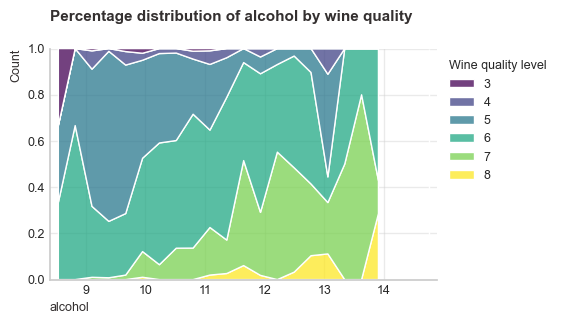

In [52]:
utils.make_polyplot(
    df_train,
    "alcohol",
    "quality",
    (5, 3),
    "Percentage distribution of alcohol by wine quality",
    "Wine quality level",
    (1, 1),
    multiple="fill",
)

The distribution plot above let's us infer that higher quality wines are supposed to have higher alcohol level.

So we can formulate the third hypothesis regarding our observation:
$$
\begin{equation*}
\begin{array}{l}
H_03: \text{Alcohol has a negative or no impact on perceived wine quality} \\
H_A3: \text{Alcohol has a positive impact on perceived wine quality} \\
\alpha = 0.05
\end{array}
\end{equation*}
$$


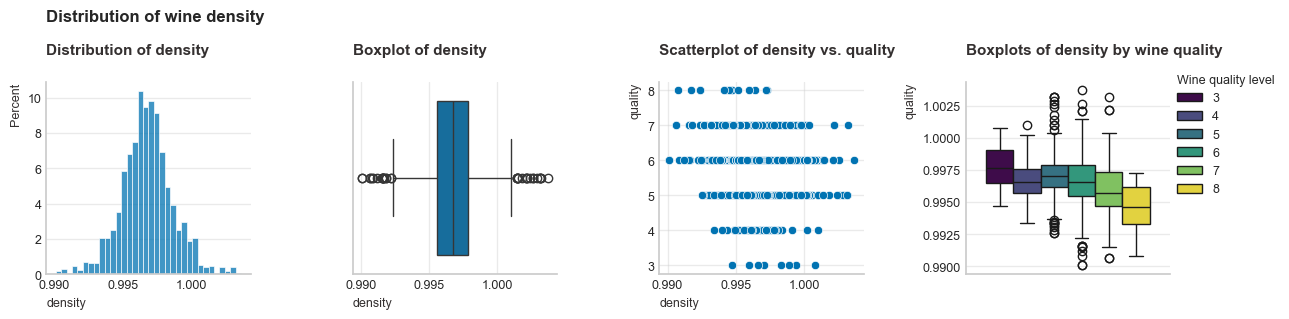

,count,mean,std,min,25%,50%,75%,max
density,1279.00,1.00,0.00,0.99,1.00,1.00,1.00,1.00


In [54]:
utils.plot_numerical_feature_distribution(
    df_train,
    (14.5, 2.5),
    ["density"],
    "quality",
    0.2,
    1.17,
    0.5,
    0.5,
    "Distribution of wine density",
)

Density has roughly normal distribution. Outliers mainly present in 5th and 6th classes. From the boxplots by wine quality we see that as wine median density decrease, its perceived quality increase.

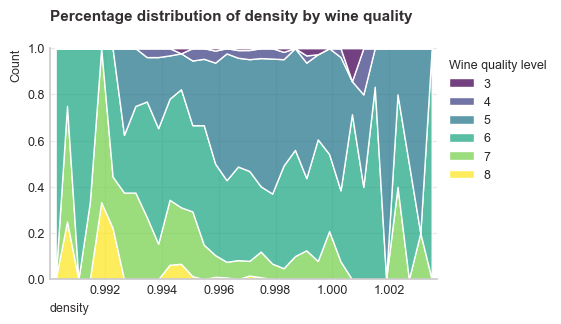

In [56]:
utils.make_polyplot(
    df_train,
    "density",
    "quality",
    (5, 3),
    "Percentage distribution of density by wine quality",
    "Wine quality level",
    (1, 1),
    multiple="fill",
)

The plot above proves the reverse relationship between wine density and perceived wine quality.

So we can formulate the fourth hypothesis regarding our observation:
$$
\begin{equation*}
\begin{array}{l}
H_04: \text{Density has a positive or no impact on perceived wine quality} \\
H_A4: \text{Density has a negative impact on perceived wine quality} \\
\alpha = 0.05
\end{array}
\end{equation*}
$$

Let's explore other features:

* Chlorides - primarily sodium chloride (salt) — represents the salt content. High levels can come from poor water used in winemaking or from proximity to sea. Excessive chlorides = salty or metallic taste. Higher chloride levels often correlate negatively with wine quality.

* pH - measures acidity strength. Lower pH = higher acidity. Optimal pH ensures balance. Too high = flat taste + spoilage risk.

* Sulphates - mostly potassium sulphate — used as an antimicrobial and antioxidant. Helps preserve wine, adds to dryness. Excessive levels = bitter taste. Mild positive correlation with quality if in balance.

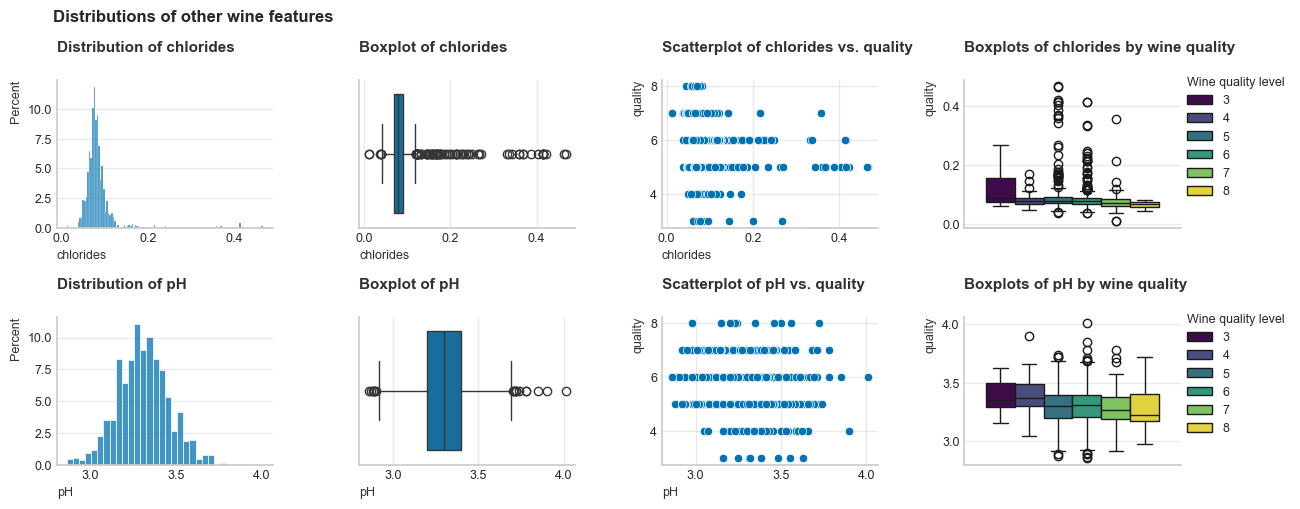

,count,mean,std,min,25%,50%,75%,max
chlorides,1279.00,0.09,0.04,0.01,0.07,0.08,0.09,0.47
pH,1279.00,3.31,0.15,2.86,3.20,3.30,3.40,4.01


In [59]:
utils.plot_numerical_feature_distribution(
    df_train,
    (14.5, 5),
    ["chlorides", "pH"],
    "quality",
    0.219,
    1.02,
    0.4,
    0.6,
    "Distributions of other wine features",
)

Chlorides has positively skewed distribution, outliers present in the 4-7th perceived quality classes, but median chlorides concentration is nearly equal for all perceived quality classes.

pH has a roughly normal distribution, outliers mainly present in most popular classes of 5-7. Median chlorides level seems to slowly decrease as wine quality increases.

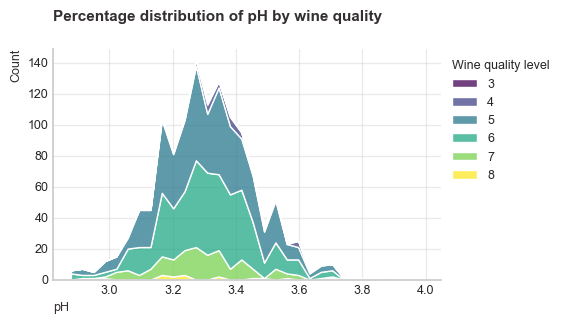

In [61]:
utils.make_polyplot(
    df_train,
    "pH",
    "quality",
    (5, 3),
    "Percentage distribution of pH by wine quality",
    "Wine quality level",
    (1, 1),
    multiple="stack",
)

From this plot we can see that pH are distributed quite similar among different wine quality classes.

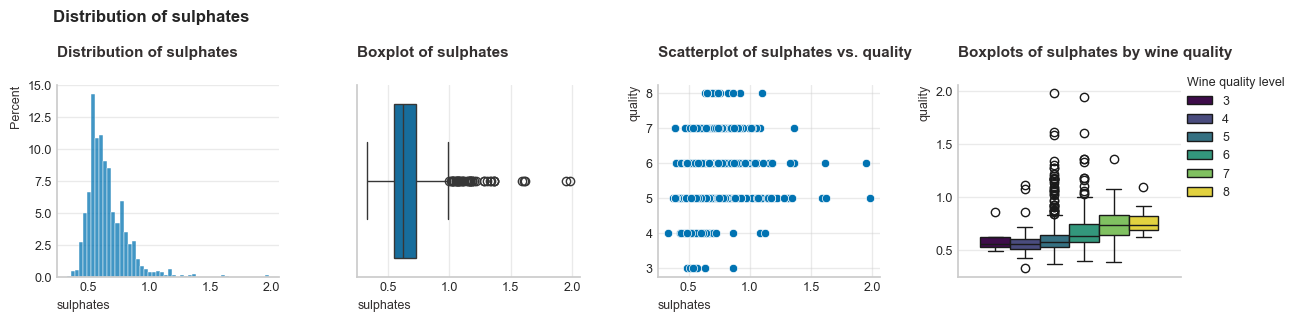

,count,mean,std,min,25%,50%,75%,max
sulphates,1279.00,0.66,0.16,0.33,0.55,0.62,0.73,1.98


In [63]:
utils.plot_numerical_feature_distribution(
    df_train,
    (14.5, 2.5),
    ["sulphates"],
    "quality",
    0.19,
    1.18,
    0.35,
    0.5,
    "Distribution of sulphates",
)

Sulphates has a positively skewed distribution, outliers mainly present in the 5th and 6th perceived quality classes. We can notice a trend of increasing sulphates as wine quality increases.

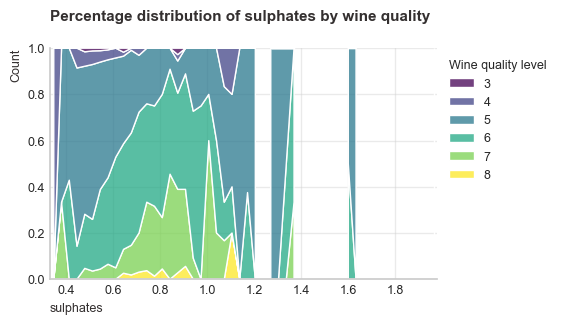

In [65]:
utils.make_polyplot(
    df_train,
    "sulphates",
    "quality",
    (5, 3),
    "Percentage distribution of sulphates by wine quality",
    "Wine quality level",
    (1, 1),
    multiple="fill",
)

This plot is affected by outliers mainly in middle perceived wine quality classes, so a trend we noticed from boxplots is not as visible here.

So we can formulate the fifth hypothesis regarding our observation:
$$
\begin{equation*}
\begin{array}{l}
H_05: \text{Sulphates has a negative or no impact on perceived wine quality} \\
H_A5: \text{Sulphates has a positive impact on perceived wine quality} \\
\alpha = 0.05
\end{array}
\end{equation*}
$$


Finally, we are left with sulfur dioxide features. 
* Free Sulfur Dioxide - the active portion of added sulfur — prevents microbial growth and oxidation. High amounts can cause a chemical taste or sulfur smell. Needs to be balanced — too little = spoilage risk, too much = off flavors.

* Total Sulfur Dioxide - indicates overall preservative level. Very high levels are undesirable and may indicate over-processing or poor fermentation hygiene.

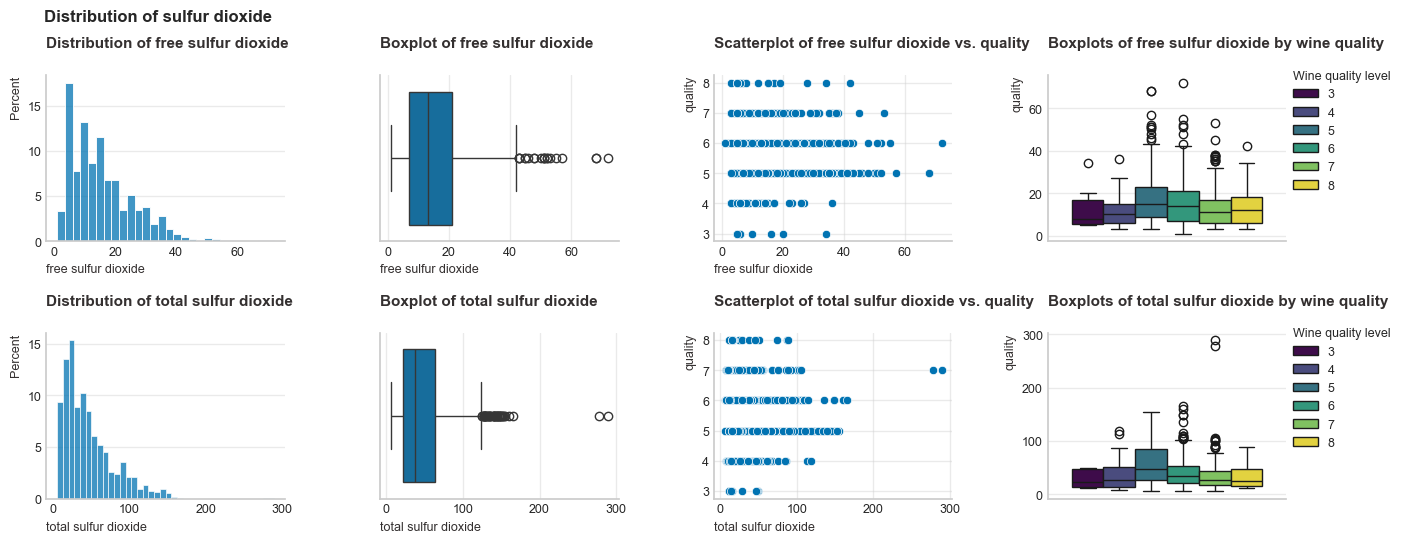

,count,mean,std,min,25%,50%,75%,max
free sulfur dioxide,1279.00,15.75,10.29,1.00,7.00,13.00,21.00,72.00
total sulfur dioxide,1279.00,46.76,33.52,6.00,22.00,38.00,63.00,289.00


In [68]:
utils.plot_numerical_feature_distribution(
    df_train,
    (16, 5.5),
    ["free sulfur dioxide", "total sulfur dioxide"],
    "quality",
    0.195,
    1,
    0.4,
    0.55,
    "Distribution of sulfur dioxide",
)

We can notice that both free and total sulfur dioxide have positively skewed distributions. Outliers for free sulfut dioxide are present in the 5-7 perceived quality classes. For total sulfur dioxide outliers mainly present in the 6-7 quality classes. Neither free, nor total sulfur dioxide seems to have huge impact on perceived wine quality.

Finally, we will examine distribution of the response variable - perceived wine quality level.

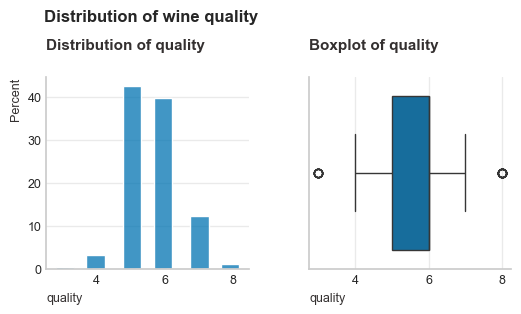

,count,mean,std,min,25%,50%,75%,max
quality,1279.00,5.64,0.81,3.00,5.00,6.00,6.00,8.00


In [71]:
utils.plot_numerical_feature_distribution(
    df_train,
    (6, 2.5),
    ["quality"],
    None,
    0.3,
    1.15,
    0.3,
    0.4,
    "Distribution of wine quality",
    shrink=3,
)

We can see that majority of wine samples are for the 5th and 6th perceived wine quality classes, so we have data imbalance, since other wine quality classes are very poorly represented and this can effect model's robustness and accuracy.

Since response variable is ordinal, we will calculate Spearman's correlation coefficient for our predictors vs predictors and predictors vs response correlation. Spearman's correlation coefficient measures:
* Monotonic relationship (not necessarily linear), based on ranked data.

Does NOT assume:

* Normal distribution.
* Linear relationship.
* Works on ordinal, non-parametric data.
* More robust to outliers and non-linear but monotonic trends.

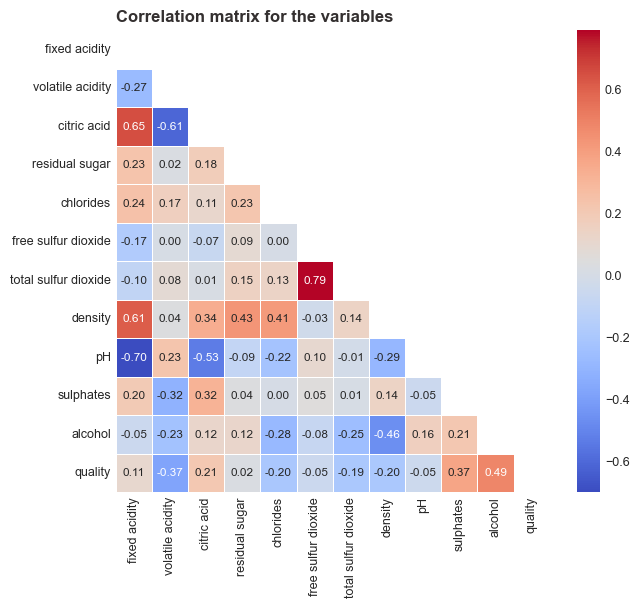

In [74]:
utils.plot_triangle_heatmap(
    df_train.corr(method="spearman"),
    (7, 6),
    8.5,
    "Correlation matrix for the variables",
    float_precision=".2f",
)

From correlation matrix above we see that fixed acidity has quite strong positive monotonic association with density (r=0.61) and citric acid (r=0.65) but negatively associated with pH (r=-0.70). Citric acid is negatively associated with volatile acidity (r=-0.61). pH has a moderate negative association with citric acid (r=-0.53). 

Since free sulfur dioxide is part of free sulfur dioxide, they are strongly positively associated (r=0.79) and they may confound each other's effects in a simple bivariate analysis.

Wine quality is moderately positively associated with alcohol (r=0.49) and sulphates (r=0.37), but moderately negatively associated with volatile acidity (r=-0.37).

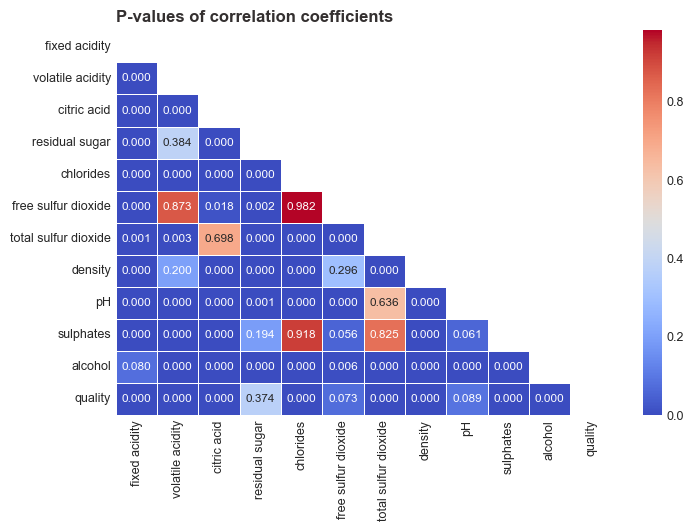

In [76]:
utils.plot_triangle_heatmap(
    df_train.corr(method=lambda x, y: spearmanr(x, y)[1]),
    (8, 5),
    8.5,
    "P-values of correlation coefficients",
    float_precision=".3f",
)

From the p-values above we can conclude that our mentioned variables for the most significant pair-wise associations are statistically significant.

Further let's explore how the spread of mostly associated predictors looks on the scatterplots.

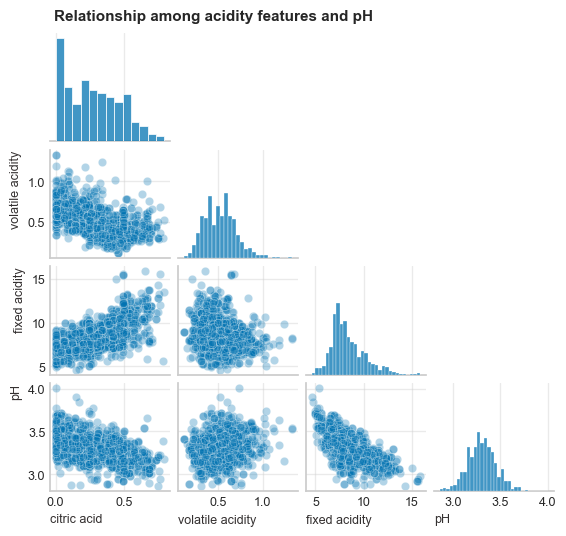

In [79]:
utils.make_pairplot(
    df_train,
    ["citric acid", "volatile acidity", "fixed acidity", "pH"],
    1.3,
    1.1,
    0.3,
    "Relationship among acidity features and pH",
    0.38,
    1.02,
)

From the plot above we see that strongest positive association is between fixed acidity and citric acid since citric acid falls into fixed acidity. Negative association is the strongest between volatile acidity and citric acid, ph and citric acid, ph and fixed acidity.

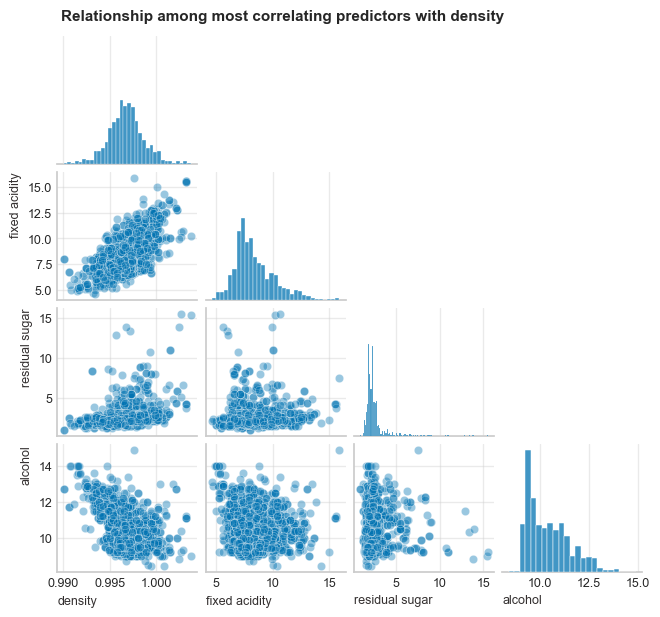

In [81]:
utils.make_pairplot(
    df_train,
    ["density", "fixed acidity", "residual sugar", "alcohol"],
    1.5,
    1.1,
    0.4,
    "Relationship among most correlating predictors with density",
    0.42,
    1.02,
)

Density and fixed acidity seem to be quite strongly positively associated. Alcohol and density are negatively associated.

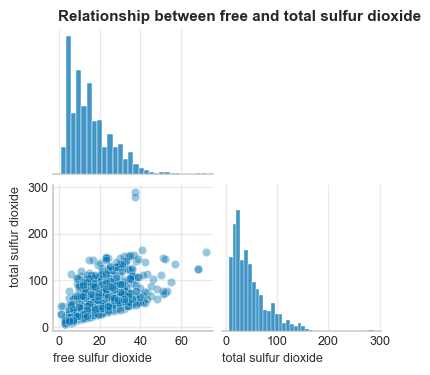

In [83]:
utils.make_pairplot(
    df_train,
    ["free sulfur dioxide", "total sulfur dioxide"],
    1.8,
    1.1,
    0.4,
    "Relationship between free and total sulfur dioxide",
    0.61,
    1.02,
)

Free and total sulfur dioxide are positively associated since free sulfur dioxide is part of total sulfur dioxide.

**Key Insights**:   
From the exploratory data analysis of our training dataset we observed those main points:
* We have 156 duplicated samples that are unique wine samples but with identical wine physicochemical characteristics.
* ~80% of our training samples belong to the 5th and 6th quality classes, so our dataset is imbalanced.
* We have noticed that wine quality is positively associated with citric acid, alcohol and sulphates.
* Negative association of wine quality with volatile acidity and density was noticed.
* pH is negatively associated with fixed and citric acidity.
* Density is negatively associated with alcohol, but positively with fixed acidity.
* Features that are part of another feature are positively associated: citric acid falls into fixed acidity, free sulfur dioxide falls into total sulfur dioxide.

### **2. Multiple Linear Regression Modelling**

#### **2.1. Transforming the Predictors**

First we will check again in a detail those predictors, which have quite skewed distributions to reduce the effect of outliers. We will normalize distributions of those features using the most appropriate transformations.

For fixed acidity feature we choose logarithm transformation, since data is positive, positively skewed, and this transformation compresses extreme values, yielding more symmetric distribution.

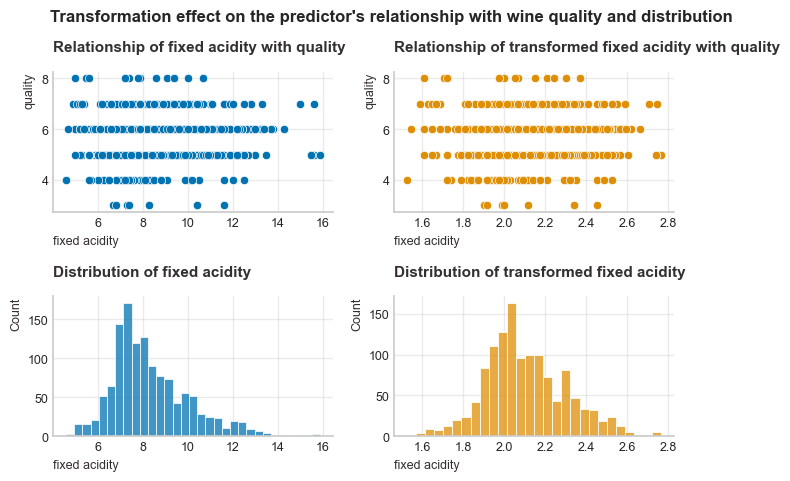

In [90]:
utils.make_transformed_feature_plots(
    df_train,
    "fixed acidity",
    np.log,
    "quality",
    (7, 5),
    0.57,
    0.96,
    "Transformation effect on the predictor's relationship with wine quality and distribution",
)

For citric acid we will use square root since there are no very extreme values, but the original distribution itself is skewed. 

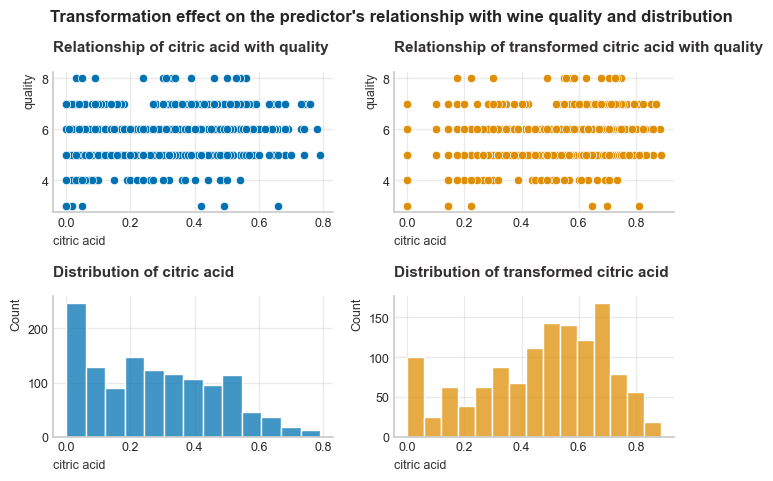

In [92]:
utils.make_transformed_feature_plots(
    df_train,
    "citric acid",
    np.sqrt,
    "quality",
    (7, 5),
    0.57,
    0.96,
    "Transformation effect on the predictor's relationship with wine quality and distribution",
)

For residual sugar we choose logarithm transformation, since there are extreme values in the positively skewed distributed which need to be compressed.

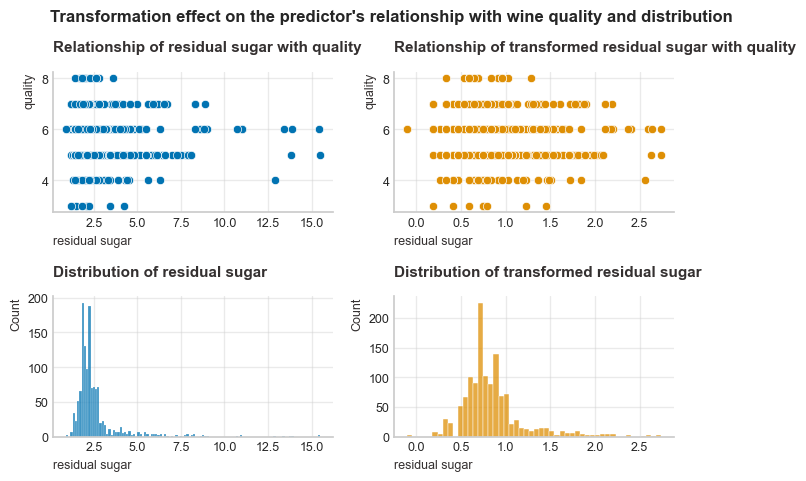

In [94]:
utils.make_transformed_feature_plots(
    df_train,
    "residual sugar",
    np.log,
    "quality",
    (7, 5),
    0.57,
    0.96,
    "Transformation effect on the predictor's relationship with wine quality and distribution",
)

For chlorides we will use logarithm transformation as well since we have positively skewed distribution with extreme values.

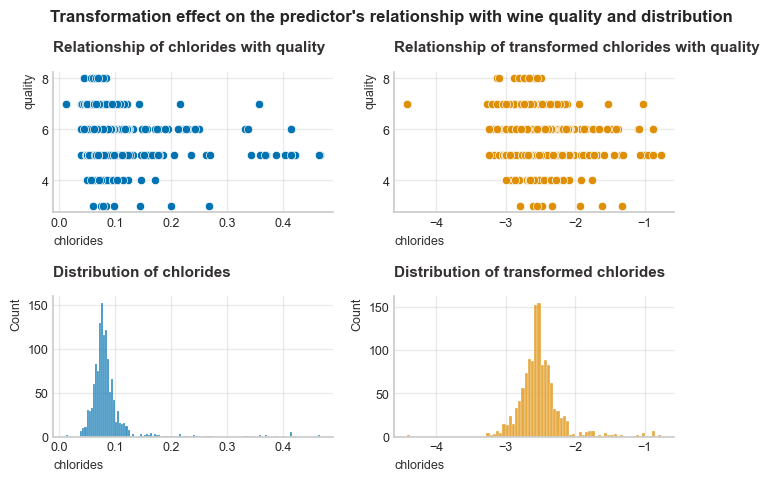

In [96]:
utils.make_transformed_feature_plots(
    df_train,
    "chlorides",
    np.log,
    "quality",
    (7, 5),
    0.57,
    0.96,
    "Transformation effect on the predictor's relationship with wine quality and distribution",
)

For alcohol we could choose either logarithm or square root transformation, since distribution is positively skewed but not extremely. However, we will use logarithm which compresses values and normalize distribution more.

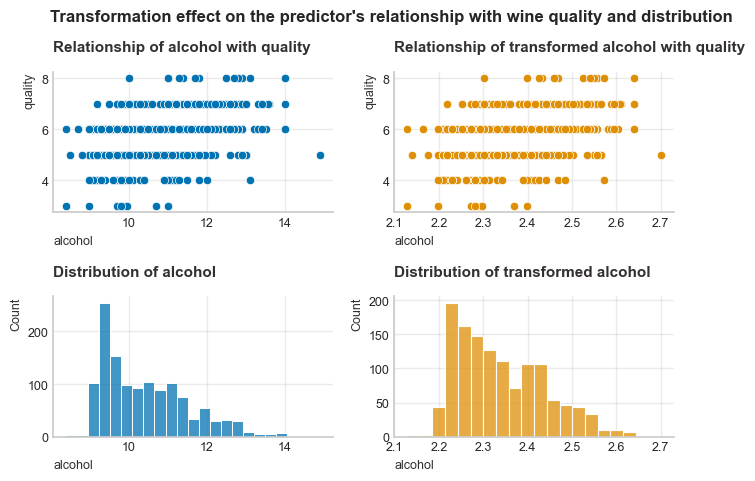

In [98]:
utils.make_transformed_feature_plots(
    df_train,
    "alcohol",
    np.log,
    "quality",
    (7, 5),
    0.57,
    0.96,
    "Transformation effect on the predictor's relationship with wine quality and distribution",
)

For sulphates we will obviously use logarithm transformation, since distribution is positively skewed with extreme values, which need to be compressed.

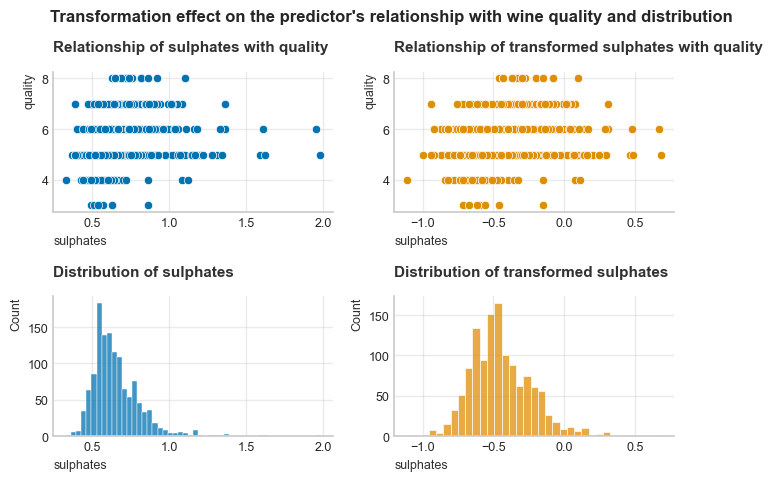

In [100]:
utils.make_transformed_feature_plots(
    df_train,
    "sulphates",
    np.log,
    "quality",
    (7, 5),
    0.57,
    0.96,
    "Transformation effect on the predictor's relationship with wine quality and distribution",
)

Free sulfur dioxide also will be transformed by logarithm that compresses positively skewed and have extreme values to be compressed.

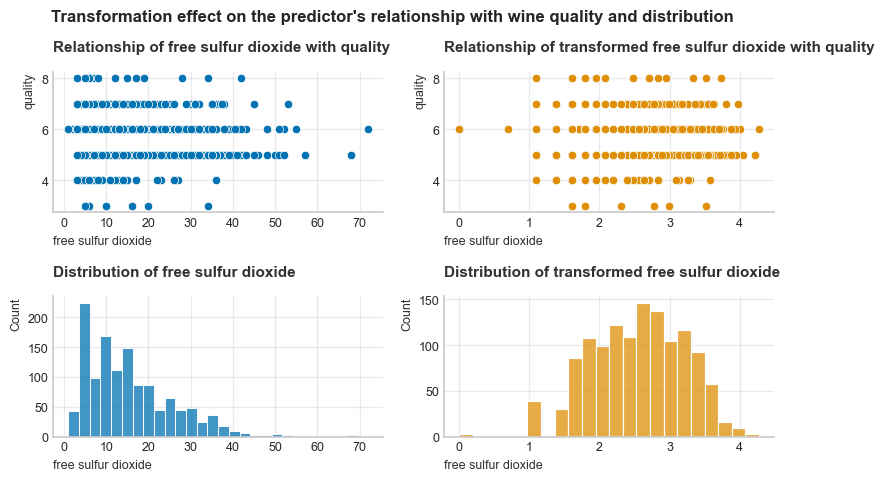

In [102]:
utils.make_transformed_feature_plots(
    df_train,
    "free sulfur dioxide",
    np.log,
    "quality",
    (8, 5),
    0.5,
    0.96,
    "Transformation effect on the predictor's relationship with wine quality and distribution",
)

Finally, total sulfur dioxide will be also transformed using logarithm, since positively and highly skewed distribution needs more 'aggresive' normalization then square root could provide.

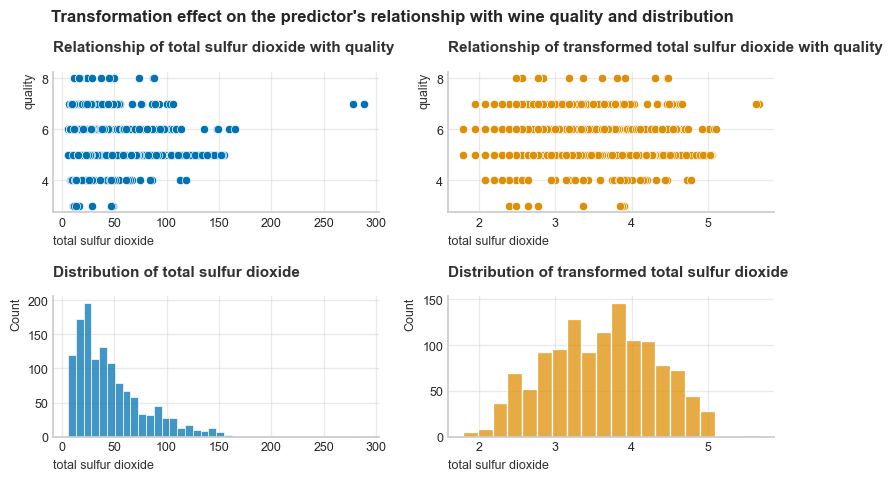

In [104]:
utils.make_transformed_feature_plots(
    df_train,
    "total sulfur dioxide",
    np.log,
    "quality",
    (8, 5),
    0.5,
    0.96,
    "Transformation effect on the predictor's relationship with wine quality and distribution",
)

Now we perform chosen transformation on the predictors to get transformed features dataframe and scale them with Standard Scaler, so that each feature has a mean of zero and standard deviation of one.

In [106]:
cols = df_train.columns[:-1]
transform_funcs = [
    np.log,
    None,
    np.sqrt,
    np.log,
    np.log,
    np.log,
    np.log,
    None,
    None,
    np.log,
    np.log,
]

scaler = StandardScaler()
df_train_transf_scaled = utils.transform_and_scale_predictors(
    cols, transform_funcs, df_train, scaler
)
df_train_transf_scaled.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
952,0.010920,-1.217262,0.711485,-0.166738,-1.044437,-1.099310,-1.832201,-0.733830,0.015760,0.273800,0.770772
563,-0.371747,-1.330165,1.007335,0.401527,0.375994,0.994742,0.691994,0.183219,0.015760,-0.222214,-0.260764
150,-0.574568,-1.104359,0.944111,-0.295822,-0.171996,-1.366836,-1.697930,-0.501932,0.145809,-0.864100,-0.065105
202,-0.931882,-0.144682,-0.606009,-1.229467,-0.253024,0.339891,0.406682,-0.686396,0.340881,0.958415,-0.871868
638,-0.305916,2.198058,-0.541413,-0.166738,1.733957,-0.873120,-0.658815,-0.185708,0.275857,0.067784,-0.162455


We can check if predictors' mean and standard deviation really changed after scaling.

In [108]:
np.round(df_train_transf_scaled.mean(), 1)

fixed acidity           0.0
volatile acidity        0.0
citric acid            -0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide   -0.0
density                -0.0
pH                     -0.0
sulphates              -0.0
alcohol                 0.0
dtype: float64

In [109]:
np.round(df_train_transf_scaled.std(), 1)

fixed acidity           1.0
volatile acidity        1.0
citric acid             1.0
residual sugar          1.0
chlorides               1.0
free sulfur dioxide     1.0
total sulfur dioxide    1.0
density                 1.0
pH                      1.0
sulphates               1.0
alcohol                 1.0
dtype: float64

We see that scaling was successfully made.

#### **2.2. Checking Multicollinearity**

Next we will make design matrix for our model and before modelling we must check if multicollinearity is present in our model matrix. (Multi)collinearity reduces the accuracy of the estimates of the regression coefficients, it causes standard errors for a certain coefficient to grow. Hence, t-statistics are reduced by (multi)collinearity and power of the hypothesis tests is diminished as well.

For this purpose we will calculate Variance Inflation Factor (VIF) for each predictor. VIF value that exceeds 5 or 10 indicates a problematic amount of multicollinearity.

In [113]:
X = add_constant(df_train_transf_scaled)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns[1:]
vif_data["VIF"] = [round(VIF(X, i), 4) for i in range(1, X.shape[1])]
vif_data["Possible multicollinearity"] = vif_data["VIF"] > 5
vif_data

,Feature,VIF,Possible multicollinearity
0,fixed acidity,7.8690,True
1,volatile acidity,1.7818,False
2,citric acid,2.6210,False
3,residual sugar,1.8883,False
4,chlorides,1.3589,False
5,free sulfur dioxide,2.8783,False
6,total sulfur dioxide,3.2362,False
7,density,7.2300,True
8,pH,3.4890,False
9,sulphates,1.3492,False


We see that *fixed acidity* and *density* have VIF greater then 7. However, we will leave those predictors in the initial model and eliminate predictors one by one according to p-values. 

#### **2.3. Multiple Regression Models and their Comparison**

The purpose of our model is inference or explanatory model that helps understand which features affect perceived wine quality.

For multiple linear regression model evaluation and comparison with other models we will use those metrics:
* **MAE** (Mean Absolute Error) - evaluate overall magnitude of average model residuals in original units;

* **RSE** (Residual Standard Error) - the square root of the sum of squared residuals divided by the residual degrees of freedom (n - p - 1). RSE gives an unbiased estimate of the true error variance under the linear-model assumptions. It is an average amount that the response will deviate from the true regression line. RSE is considered a measure of the lack of fit of the model to the data.

* **Adjusted R squared** - explain how much variability in the response is explained by the model, adjusted for number of predictors and balances fit with parsimony, to see if predictors meaningfully add explanatory power;

* **AIC** (Akaike Information Criteria) - evaluates model fit and complexity, lower AIC means better balance between goodness-of-fit and simplicity;

* **BIC** (Bayesian Information Criteria) - similar to AIC, but has heavier penalty for complexity.

Now let's make our first multiple regression model with all the features:

In [119]:
results1, RSE1, MAE1 = utils.fit_linear_regression_and_get_results(y_train, X)

RSE: 0.6478, 
MAE: 0.4948
                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     65.83
Date:                Mon, 19 May 2025   Prob (F-statistic):          3.54e-116
Time:                        11:49:36   Log-Likelihood:                -1253.5
No. Observations:                1279   AIC:                             2531.
Df Residuals:                    1267   BIC:                             2593.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const 

From the summary statistics we see that *citric acid* has the largest p-value (0.407) from all other statistically insignificant predictors. For right-tailed t-test p-value would be 0.407/2 = 0.2035, higher then our alpha=0.05. So we fail to reject our null hypothesis that citric acid has a negative or no impact on perceived wine quality.

Hence, we will eliminate it and make multiple regression model again.

In [121]:
X_minus_citric = X.drop("citric acid", axis=1)
results2, RSE2, MAE2 = utils.fit_linear_regression_and_get_results(
    y_train, X_minus_citric
)

RSE: 0.6478, 
MAE: 0.4953
                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     72.37
Date:                Mon, 19 May 2025   Prob (F-statistic):          5.70e-117
Time:                        11:49:36   Log-Likelihood:                -1253.9
No. Observations:                1279   AIC:                             2530.
Df Residuals:                    1268   BIC:                             2586.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const 

Now we see that the coefficient for *fixed acidity* decreased and we got p-value even greater then before (0.51). We remember that this feature had VIF value greatest from all the other features (7.9). R square adjusted hasn't changed (0.358). We will eliminate this feature, and see the changes in the model.

In [123]:
X_minus_citric_fixed = X.drop(["citric acid", "fixed acidity"], axis=1)
results3, RSE3, MAE3 = utils.fit_linear_regression_and_get_results(
    y_train, X_minus_citric_fixed
)

RSE: 0.6476, 
MAE: 0.4955
                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     80.39
Date:                Mon, 19 May 2025   Prob (F-statistic):          7.65e-118
Time:                        11:49:36   Log-Likelihood:                -1254.1
No. Observations:                1279   AIC:                             2528.
Df Residuals:                    1269   BIC:                             2580.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const 

After removing *citric acid* and *fixed acidity* we see that R squared adjusted raised a little (from 0.358 to 0.359). AIC and BIC metrics also decreased as less predictors are in the model. The next insignificant predictor is *residual sugar* with p-value (0.469). Let's remove it and see how the model metrics change.

In [125]:
X_minus_citric_fixed_sugar = X.drop(
    ["citric acid", "fixed acidity", "residual sugar"], axis=1
)
results4, RSE4, MAE4 = utils.fit_linear_regression_and_get_results(
    y_train, X_minus_citric_fixed_sugar
)

RSE: 0.6475, 
MAE: 0.496
                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     90.41
Date:                Mon, 19 May 2025   Prob (F-statistic):          1.01e-118
Time:                        11:49:36   Log-Likelihood:                -1254.4
No. Observations:                1279   AIC:                             2527.
Df Residuals:                    1270   BIC:                             2573.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const  

We see that R squared adj. remains unchanged (0.359), AIC and BIC decreased once more. The last predictor that is left insignificant is *density* with p-value (0.356). It is also the predictor which had second largest VIF value (7.2). In addition, we fail to reject our null hypothesis that density has a positive or no effect on perceived wine quality, since left-tailed p-value is 0.356/2 = 0.178 > 0.05.

Let's remove it and make a model again.

In [127]:
X_minus_citric_fixed_sugar_density = X.drop(
    ["citric acid", "fixed acidity", "residual sugar", "density"], axis=1
)
results5, RSE5, MAE5 = utils.fit_linear_regression_and_get_results(
    y_train, X_minus_citric_fixed_sugar_density
)

RSE: 0.6474, 
MAE: 0.4955
                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     103.2
Date:                Mon, 19 May 2025   Prob (F-statistic):          1.46e-119
Time:                        11:49:36   Log-Likelihood:                -1254.8
No. Observations:                1279   AIC:                             2526.
Df Residuals:                    1271   BIC:                             2567.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const 

After removing all insignificant predictors we see that adjusted R squared remained 0.36 for all the models. What means that 36% of variation in wine quality is explained by the predictors in the model. So 63% of variation in repsonse is still left unexplained. So our model has quite weak explanatory power.

A few more important metrics to consider:

* Omnibus test statistic informs us about normality of the residuals, and we get very low p-value (0.000) and high test statistic  - so residuals are non-normally distributed.

* Durbin Watson - tests for autocorrelation in residuals. In our case it is 2.122 suggesting no autocorrelation.

* Jarque-Bera test - checks whether residuals are normally distributed based on skew and curtosis - very low p-value (1.03e-09) suggest non-normal residuals.

* Cond. No. - indicates potential multicollinearity among predictors. Number above 30 suggests significant multicollinearity. In our case (3.07) there is no serious multicollinearity.

Furthermore, we can come back to our remaining hypothesis. With 95% confidence we can state that:

* alcohol - we reject the null hypothesis that alcohol has a negative or no impact on perceived wine quality, 95% confidence interval for alcohol coefficient (0.297) is (0.257, 0.337).

* volatile acidity - we reject the null hypothesis that volatile acidity of wine has a positive or no impact on perceived wine quality, 95% confidence interval for volatile acidity coefficient (-0.152) is (-0.192, -0.112).

* sulphates - we reject the null hypothesis that sulphates has a negative or no impact on perceived wine quality, 95% confidence interval for sulphates coefficient (0.173) is (0.134, 0.213). 

Now let's fill a table with metrics for our model comparison and plot them.

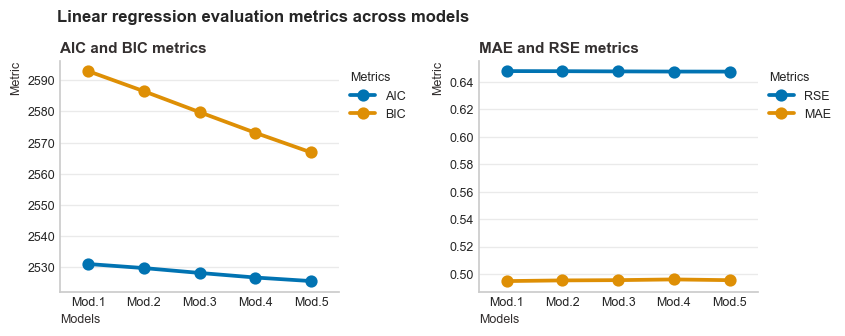

In [130]:
results = [results1, results2, results3, results4, results5]
RSE_list = [RSE1, RSE2, RSE3, RSE4, RSE5]
MAE_list = [MAE1, MAE2, MAE3, MAE4, MAE5]
utils.compare_regression_models(
    results,
    RSE_list,
    MAE_list,
    (9, 3),
    "Linear regression evaluation metrics across models",
    0.35,
    1.05,
    0.5,
)

We see that after regressing wine quality as a continuous variable on 11 predictor in Model 1 to 7 predictors in Model 5, MAE and RMSE haven't changed a lot. However, AIC metric became a little better, and removing insignificant predictors diminshed BIC, which is more concerned about model complexity and prefers a simplier one.

Finally, we can compare models using ANOVA function.

In [132]:
anova_lm(results1, results2, results3, results4, results5)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1267.0,531.741698,0.0,NaN,NaN,NaN
1,1268.0,532.031006,-1.0,-0.289309,0.690160,NaN
2,1269.0,532.213144,-1.0,-0.182138,0.434498,NaN
3,1270.0,532.433289,-1.0,-0.220145,0.525168,NaN
4,1271.0,532.791139,-1.0,-0.357850,0.853668,NaN


As we eliminated features one by one with p-values lower then statistical significance level (alpha=0.05), we got Sum of Squared Residuals increasing little by little so our model performance wasn't getting better after eliminating non-significant features. However, small F statistic values let's us conclude that removing non-significant predictors, have low impact on the model. This is supported by stable MAE and RSE across different models.

**Key Insights**:    
* We have failed to reject two from stated five hypothesis - density and citric acid appears to have no significant impact on perceived wine quality;
* We rejected three null hypothesis - there is evidence that alcohol and sulphates has a positive, and volatile acidity has a negative impact on perceived wine quality;
* Comparing our multiple linear regression models we have found out that after eliminating insignificant features, like: density, citric acid, residual sugar, and fixed acidity we got a simplier model though across this process RSE and MAE left quite stable.

#### **2.4. Checking Linear Regression Assumptions**

After we have performed modelling, we must check if linear regression model assumptions are satisfied.

Linear Regression Model has those main assumptions:

* Linearity - the relationship between the response and predictors is linear ->   
We will use partial residuals and partial regression plots as well as residuals vs. fitted values plot to examine this assumption.

* Independence of Errors - residuals should be not correlated ->   
Durbin Watson metric should be close to 2. In all five our models this metric is ~2.1. So this assumption is satisfied.

* Homoscedasticity (Constant Variance of the Errors) - the residuals are equally spread across the range of all fitted values ->   
We will make residuals vs. fitted values, and perform White's test.

* Normality of Residuals - errors are normally distributed ->   
We got Omnibus and Jarque-Bera tests suggesting non-normal residuals. We will make Q-Q plot, histogram of residual and perform Shapiro-Wilk test to examine this important assumption in a more detail.

* No Multicollinearity - predictors are not highly correlated ->   
We have calculated VIF metric and have found out that only fixed acidity and density have VIF higher then 5 (~7.9 and ~7.2 respectively). 
These two features were removed from the last model which contains only statistically significant independent variables.

* No Influential Outliers - no single point has undue influence ->   
We will calculate Cook's distance to check if this assumption is met together with DFFITS and influence plot.

##### **2.4.1. Linearity Assumption**

Linearity assumption among response variable and predictors is one of the key assumptions for linear regression model. Let's first check this making residuals vs. fitted values plot.

Since our model produces wine quality scores in a continous scale, we will round scores with a decimal lower then 0.5 to the nearest smaller integer and with decimal value greater then 0.5 we will round to the nearest higher integer value.

In [140]:
fitted5_rounded = utils.customize_response(results5.fittedvalues)
resid5_rounded = utils.customize_response(results5.resid)
pd.Series(fitted5_rounded).value_counts()

6.0    648
5.0    568
7.0     61
4.0      2
Name: count, dtype: int64

Below we will plot residuals vs fitted values plot to check if linearity assumption applies in our case.

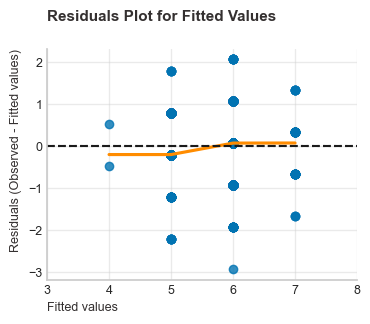

In [142]:
utils.plot_residuals_fitted_values(results5, (4, 3))

The orange line indicates the fit of a locally weighted scatterplot smoothing (LOWESS), a local regression method, to the residual scatterplot. Local regression is a different approach for fitting flexible non-linear functions, which involves computing the fit at a target point x using only the nearby training observations.
 
 We see that residuals are discrete values and there seems to be a non-random pattern in the residual scatter. LOWESS curve also deviates from the zero line, not too much, but brings doubts about fulfilled linearity assumption. So we will plot additional plots to examine each predictor in a detail.

Next we will make a component plus component residual plot (CCPR) for each predictor. CCPR is intended to show how the data would look like if all but one covariate could be fixed at reference values. By controlling the values of these covariates, all remaining variation is due to either the 'focus variable' (one unfixed and plotted on the horizontal axis), or to sources of variation that are unexplained by any of the covariates.

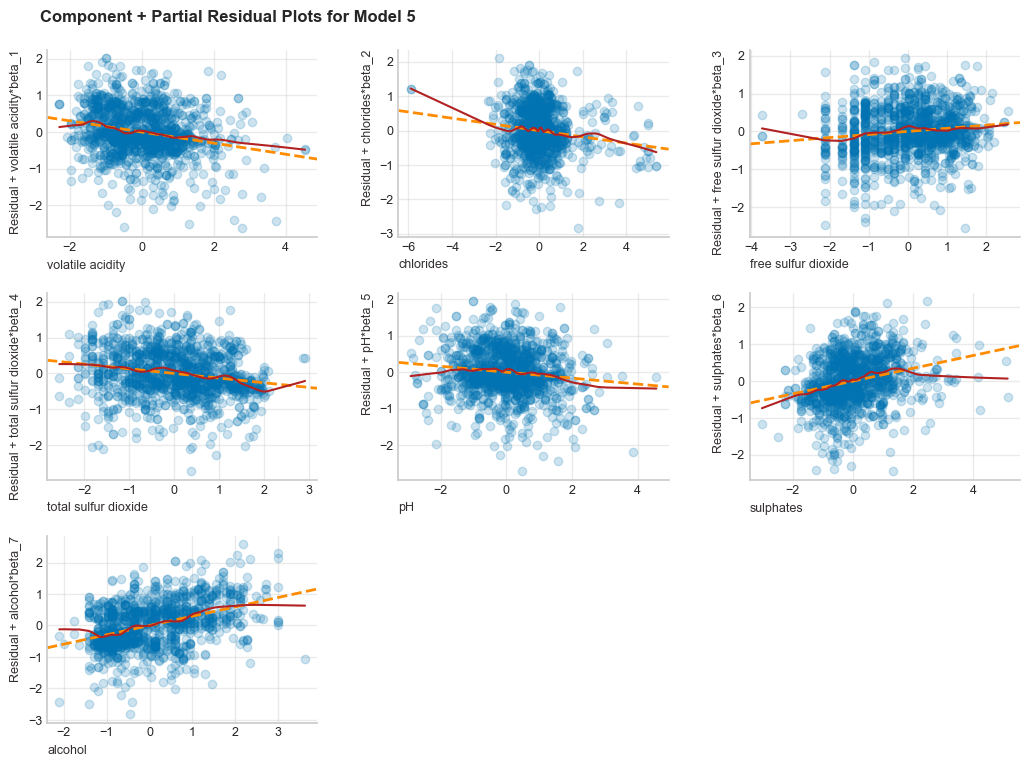

In [145]:
fig = sm.graphics.plot_ccpr_grid(results5, grid=(3, 3))
utils.make_subplots_grid(
    fig,
    11,
    8,
    0.2,
    "darkorange",
    "firebrick",
    0.3,
    0.3,
    "Component + Partial Residual Plots for Model 5",
    0.25,
    1,
)

From the plots above we see that LOWESS curve in most CCPR plots echo linear relationship between the partial-residuals and a particular predictor but with some deviations. This nonparametric smooth curve adapts to the data shape rather then imposes a straight line on the scatter in the plot and represents the empirical trend of the partial-residual points. 

We see that a scatter of the partial-residuals is more or less clustered around a straight line. However, the LOWESS line helps us identify that for sulphates and chlorides there is more obvious evidence for non-linearity. Chlorides seems to have outlier (at -6) that impacts LOWESS curve. So we can conclude that linearity assumption is not perfectly satisfied, but we should be cautious with high leverage values and large residuals, which might impose non-linearity with response variable. Hence, checking influential observations seems to be even more important.

In addition, we will make added variable (partial regression) plots (AVP) to look at the relationship of the response variable and independent variables conditional on the other independent variables. This plot may reveal nonlinearity in the relationship between one covariate and the outcome. In addition, these plots help us discover each predictor's unique contribution to the response variable.

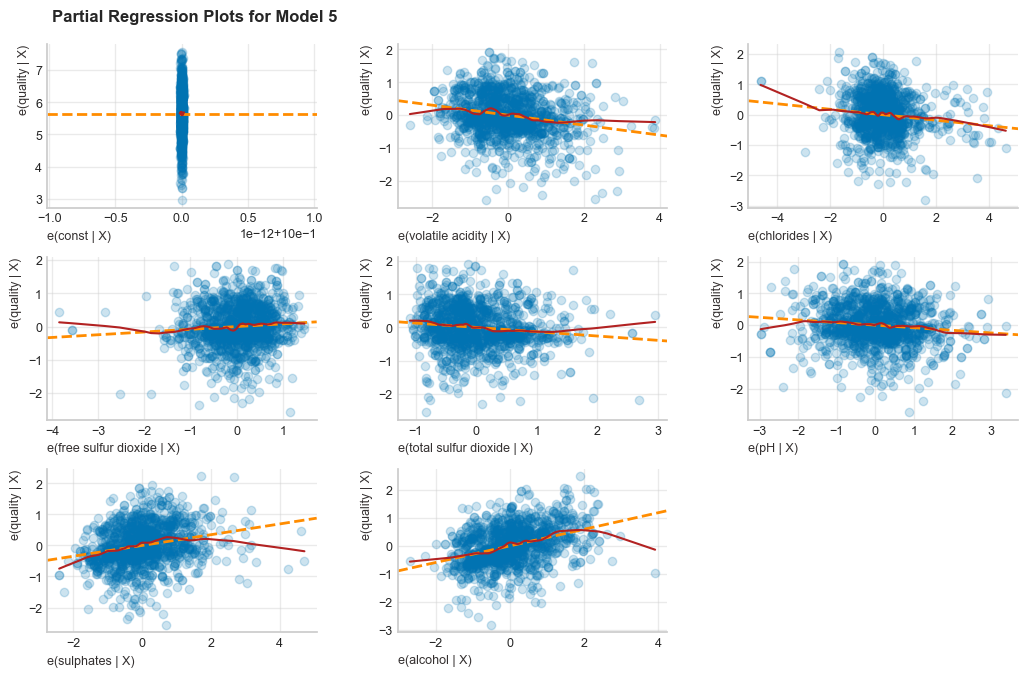

In [148]:
fig = sm.graphics.plot_partregress_grid(results5, grid=(3, 3))
utils.make_subplots_grid(
    fig,
    11,
    7,
    0.2,
    "darkorange",
    "firebrick",
    0.3,
    0.3,
    "Partial Regression Plots for Model 5",
    0.22,
    1,
)

From the partial regression plots we see that all LOWESS curves are not straight on any of the fitted lines, what let us assume nonlinearity in predictor-response relationship. We see that LOWESS curve most often deviate from the straight line in low and high ends affected by influential points. Most predictor values lie within 2 standard deviations of the predictor, only free and total sufur dioxide are quite condensed around zero and bring less unique contribution to the model (majority of the scatter lies within one standard deviation). Large residuals exceeding three standard deviations are obvious on all the subplots. Hence, diagnostics of possible influential points should be done with scrutiny, since those points can effect estimation of regression coefficients and standard errors.

The steepest positive slopes are for sulphates and alcohol, suggesting that wine quality positively correlates with those features most strongly. Volatile acidity has the steepest negative slope of all other predictors, suggesting negative impact on wine quality.    

From the plots there is obvious vertical scatter of the points ranging from -2 to 2 (difference in observed vs predicted quality class), so there is approx. similar variability in the relationship between focus variable and response after controlling for other predictors. Hence, there is still considerable unexplained variation in the response variable even after accounting for focus variable and all other predictors in the model.

Since we have reasonable doubts about linearity assumption, finally, we will perform Ramsey's RESET test (Regression Equation Specification Error Test), which is specifically designed to detect functional form misspecification in linear regression models. It formally tests whether powers of the fitted values add explanatory power, indicating functional-form misspecification. "Correct functional form" means that the mathematical relationship used in our statistical model accurately represents the true underlying relationship between the predictors and the response variable.

So we will formulate hypothesis for our test:
$$
\begin{equation*}
\begin{array}{l}
H_0: \text{Functional form of our model is correct} \\
H_A: \text{Functional form misspecification is present} \\
\alpha = 0.05
\end{array}
\end{equation*}
$$

In [151]:
res_reset = linear_reset(results5, power=4, test_type="fitted")
print(f"RESET F-statistic: {res_reset.statistic:.3f}")
print(f"RESET p-value: {res_reset.pvalue:.5f}")
if res_reset.pvalue < 0.05:
    print(
        "Functional form of our model is incorrect. Missing nonlinear or interaction terms, or link function is incorrect."
    )
else:
    print("Functional form of our model is correct.")

RESET F-statistic: 14.610
RESET p-value: 0.00218
Functional form of our model is incorrect. Missing nonlinear or interaction terms, or link function is incorrect.


**Key Insights**:
* After making partial regression and partial residual plots we have doubts if predictor-response relationship is purely linear. LOWESS curve for each predictor from our final model deviates from the straight line, especially in high and low ends.
* From the CCPR plots we can infer that because of probable observations having high leverage predictors suplhates and chlorides have nonlinear relationship with response.
* AVPs let's us assume that after adjusting for other variables sulphates and alcohol may have nonlinear relationship with response variable. These predictors also have the highest positive impact on wine quality.
* Ramsey's RESET test let's us conclude that purely linear form of our model is not the correct functional form representing true relationship between the predictors and response. There might be missing important nonlinear relationships. This test, however, is sensitive to outliers, heteroskedasticity or omitted variables. Even not correct functional form could make us reject the correctness of the current functional form.
* We see the importance to check other linear model assumptions to get better understanding why we fail with linearity assumption.

##### **2.4.2. Homoscedasticity**

From the residuals vs. fitted value plots we see the scatter of residuals seems to have a pattern. Hence, we will perform White's test to check homoscedasticity assumption.

So we will formulate our hypotheses to test homoescedasticity of the residuals and set a significance level:
$$
\begin{equation*}
\begin{array}{l}
H_0: \text{Constant variance of the residuals (homoskedasticity)} \\
H_A: \text{Not constant variance of the residuals (heteroskedasticity)} \\
\alpha = 0.05
\end{array}
\end{equation*}
$$

In [156]:
white_test = het_white(resid5_rounded, results5.model.exog)
white_labels = ["LM stat", "LM p-value", "F-stat", "F p-value"]
print("White test:")
for label, test in zip(white_labels, white_test):
    print(f"{label}: {test:.5f}")

    if "p-value" in label:
        if test < 0.05:
            print(
                f"->  We reject the null hypothesis. Residual variance is not constant. \n"
            )
        else:
            print(
                f"-> We fail to reject the null hypothesis. Residual variance is constant.\n"
            )

White test:
LM stat: 99.53035
LM p-value: 0.00000
->  We reject the null hypothesis. Residual variance is not constant. 

F-stat: 2.99690
F p-value: 0.00000
->  We reject the null hypothesis. Residual variance is not constant. 



**Key Insight**:
We have proved that residual variance is not constant. Consequences of this violated assumption:
* Standard errors may be biased and incorrect, this mean confidence intervals and p-values for coefficients are unreliable. So we may incorrectly conclude that a predictor is statistically significant or not. 
* Our OLS model becomes less efficient, and we may look for better alternatives. So we should adjust model to account for the heteroskedasticity.    

##### **2.4.3. Normality of residuals**

Since Ordinary Least Squares (OLS) model relies on normality assumption of the residuals, we will check if this assumption is satisfied using plots and performing Shapiro-Wilk test.

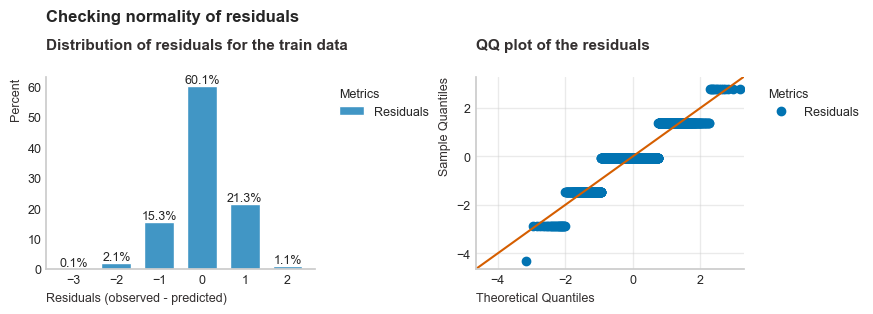

In [160]:
utils.plot_residuals_normality(
    resid5_rounded,
    "train",
    (9, 2.5),
    0.6,
    "Checking normality of residuals",
    0.265,
    1.15,
)

The histogram of the residuals shows negatively skewed distribution. From the QQ plot we see that residuals fall into separate classes and most residuals are concentrated on the zero line. These plots let's us assume that residuals are not normally distributed. Finally, we will perform Shapiro-Wilk's test.

So we will formulate our hypotheses to test normality of the residuals and set a significance level:
$$
\begin{equation*}
\begin{array}{l}
H_0: \text{Residuals are normally distributed} \\
H_A: \text{Residuals are not normally distributed} \\
\alpha = 0.05
\end{array}
\end{equation*}
$$

In [163]:
sw_stat, sw_pvalue = stats.shapiro(resid5_rounded)
print(f"Shapiro-Wilk Test: {sw_stat:.3f}, p-value: {sw_pvalue:.4f}")
if sw_pvalue < 0.05:
    print("-> We reject the null hypothesis that residuals are normally distributed.")
else:
    print(
        "-> We fail to reject the null hypothsesis. Residuals are normally distributed."
    )

Shapiro-Wilk Test: 0.821, p-value: 0.0000
-> We reject the null hypothesis that residuals are normally distributed.


**Key Insights**:   
We can conclude that residuals are not normally distributed. So this violated assumption for OLS models have the following consequences:
* Our calculated standard errors for model coefficients are biased and not correct. This affects calculated test statistics and p-values. Our confidence intervals are not reliable as well.
* Our model is not efficient to model the predictors-response true relationship.

##### **2.4.4. Influence and Leverage**

In a regression analysis a single predictor's value can have high influence on the results of the regression model. We call those points influential, if they have high leverage (predictor's value far away from the mean) and are high residuals (prediction far from observed response value).   

Next we will explore if we have such influential points that could influence our model results.

The leverage statistic is calculated for each observation, taking all the predictors into account. Leverage is about the position of the entire observation in multidimensional predictor space. If leverage statistic is far from the center of the data cloud in terms of all predictors combined, it might strongly infuence the regression coefficients and fitted values.

In [168]:
num_predict = X_minus_citric_fixed_sugar_density.shape[1] - 1
n = X_minus_citric_fixed_sugar_density.shape[0]
# The more conservative leverage threshold - 2 times average threshold
leverage_thresh = 2 * (num_predict + 1) / n

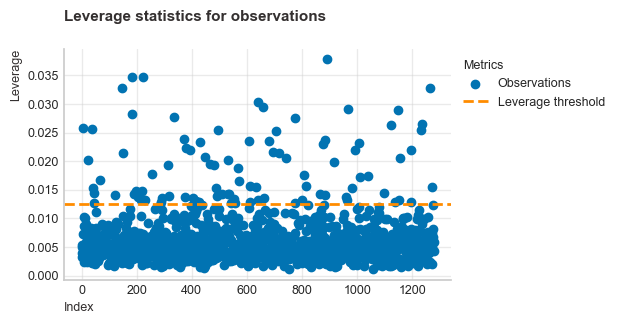

Index of the highest leverage observation  - 890


In [169]:
infl = results5.get_influence()
max_leverage = utils.plot_leverage(infl, leverage_thresh, (5, 3), X)

In [170]:
df_train.loc[df_train.index[max_leverage]]

fixed acidity            7.9000
volatile acidity         0.4000
citric acid              0.2900
residual sugar           1.8000
chlorides                0.1570
free sulfur dioxide      1.0000
total sulfur dioxide    44.0000
density                  0.9973
pH                       3.3000
sulphates                0.9200
alcohol                  9.5000
quality                  6.0000
Name: 773, dtype: float64

We see that observation having highest leverage belongs to the 6th quality class.

Now let's calculate studentized residuals (residual divided by its estimated standard error), DFBETAS and DFFITS metrics to discover more about influential observations in our dataset.

DFBETAS measures the influence of a single observation on each regression coefficient, so this method helps identify observations that skew parameter estimates.

DFFITS finds observations that disproportionately change their own predicted values. So it targets each predicted value not regression coefficient as DFBETAS.

In [173]:
leverage = infl.hat_matrix_diag
studentized_resid = infl.resid_studentized_external
dfbetas = infl.dfbetas
dffits = infl.dffits

Now we will plot studentized residuals vs leverage value to get better understanding how many observations could be influential. We consider influential those observations that are high residuals and have high leverage simultaneously.

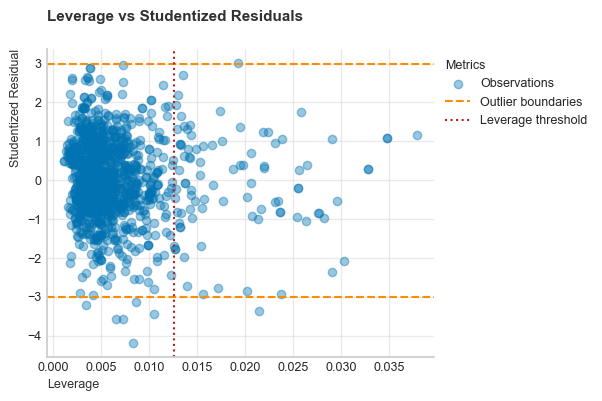

In [175]:
utils.plot_residuals_vs_leverage(
    leverage, studentized_resid, leverage_thresh, 0.4, (5, 4)
)

From the plot above we see that there is quite a lot of points that have high leverage then are large residuals. This plot suggests that there are not a lot of influential points. 

Further, we will calculate DFBETAS and DFITS to identify influential points.

In [177]:
dfbetas_df = pd.DataFrame(dfbetas, columns=X_minus_citric_fixed_sugar_density.columns)
dfbetas_df
dfbetas_thresh = 2 / (n**0.5)

print(f"DFBETAS threshold: {dfbetas_thresh:.5f}")
high_dfbetas = dfbetas_df[(dfbetas_df.abs() > dfbetas_thresh).any(axis=1)].index
print(f"Number of influential points {high_dfbetas.size}")

DFBETAS threshold: 0.05592
Number of influential points 252


In [178]:
dffits_threshold = 2 * np.sqrt((num_predict + 1) / n)
dffits, _ = infl.dffits

print(f"DFFITS threshold: {dffits_threshold:.5f}")
dffits_infl_obs = y_train[np.abs(dffits) > dffits_threshold].index
print(f"Number of influential points {dffits_infl_obs.size}")

DFFITS threshold: 0.15818
Number of influential points 83


We see that we got different amount of influential observations from both methods. So additionally we will calculate Cook's distance.

Cook's distance is a diagnostic metric in regression analysis which helps identify infuential observations - data points that significantly affect the estimated regression coefficients when included in or excluded from the model. Cook's Distance combines:
* Leverage - how far an observation's predictor values are from the mean, and
* Residual size - how far the observed response is from the predicted value.
If a point has high leverage and large residuals, it can pull the regression line toward itself and distort the model.

In [181]:
cooks_d = infl.cooks_distance[0]
# Critical value for Cook's distance
critical_dist = 4 / (n - num_predict)
print(f"Critical Cook's distance is {critical_dist:.5f}")

mask_infl = cooks_d > critical_dist
cooks_infl_obs = df_train[mask_infl].index
print(f"There are {cooks_infl_obs.size} observations with high influence.")

Critical Cook's distance is 0.00314
There are 82 observations with high influence.


Now we can compare if observations flagged as influential both by Cook's distance and DFFITS match.

In [183]:
infl_obs = list(set(cooks_infl_obs).intersection(set(dffits_infl_obs)))
print(
    f"Number of matching observations in Cook's distance and DFFITS is {len(infl_obs)}."
)

Number of matching observations in Cook's distance and DFFITS is 82.


So we see that all observations flagged as influential by Cook's distance are also found by DFFITS method.

Now we can look to which wine quality class those influential observations belong and if it would be wise remove them from the train set and fit the model again.

In [185]:
infl_obs_resp = y_train.loc[infl_obs].value_counts()
num_obs = y_train.value_counts()
pd.DataFrame(
    {
        "Detected outliers by quality": infl_obs_resp,
        "Actual observations in train set": num_obs,
    },
    index=infl_obs_resp.index,
)

,Detected outliers by quality,Actual observations in train set
quality,,
4,22,42
5,16,545
7,16,159
6,10,510
8,10,15
3,8,8


We can notice that observations from more rare classes are flagged as influential. Hence, the solution to remove them would be incorrect.

**Key Insights**:
* We failed on linearity, residuals normality and homoskedasticity assumptions.
* Non-normal and heteroskedastic residuals renders incorrect standard errors  - leading to unreliable t-tests, confidence intervals and hypotheses tests.
* Non-linear relationship of predictors with response means model bias - explanatory model should minimize this bias to obtain the most accurate representation of the underlying true relationship among predictors and response. So we have biased estimates of the true relationship, and misleading inferences. Experimenting with nonlinear predictor terms or even meaningful interaction terms could us help fix non-linearity issue.
* Our identified influential observations belong to wine quality classes that have the least amount of observations because of high data imbalance.
* Overall, we can conclude that our multiple linear regression model for this dataset lacks reliability and explanatory power is low.

#### **2.5. Interpretation of the Multiple Regression Model**

Despinte the fact that our final model is not very reliable, we will try to understand what is the effect of each predictor on the perceived wine quality. For this reason we have to rescale all the features and re-transform those which were transformed. We will estimate the impact of each predictor increase in 10% of original units on perceived wine quality on a continuous scale.

In [190]:
# Extract only selected features in the model 5
selected_features = np.r_[1, 4:7, 8 : len(cols)]
selected_cols = cols[np.r_[1, 4:7, 8 : len(cols)]]
coefs = results5.params.iloc[1:]
stds = scaler.scale_[selected_features]
transformations = ["None", "Log", "Log", "Log", "None", "Log", "Log"]

We must calculate mean and standard deviation for predictors which were not log transformed.

In [192]:
volatile_std = df_train["volatile acidity"].std(ddof=0)
volatile_mean = df_train["volatile acidity"].mean()

pH_std = df_train["pH"].std(ddof=0)
pH_mean = df_train["pH"].mean()

none_transf_stats = [(volatile_std, volatile_mean), (pH_std, pH_mean)]

Finally, we get interpreted regression coefficients:

In [194]:
marginal_changes = []
for col, std, coef, transf in zip(selected_cols, stds, coefs, transformations):
    marginal_change = utils.rescale_to_units(coef, std, 0.1, transf, none_transf_stats)
    marginal_changes.append(marginal_change)
    if transf == "None":
        key = " relative to the mean"
    else:
        key = ""

    if marginal_change < 0:
        print(
            f"A 10% increase in {col}{key} is associated with an estimated decrease of {abs(marginal_change)} in the response variable holding other variables fixed."
        )
    else:
        print(
            f"A 10% increase in {col}{key} is associated with an estimated increase of {marginal_change} in the response variable holding other variables fixed."
        )

A 10% increase in volatile acidity relative to the mean is associated with an estimated decrease of 0.0451 in the response variable holding other variables fixed.
A 10% increase in chlorides is associated with an estimated decrease of 0.0266 in the response variable holding other variables fixed.
A 10% increase in free sulfur dioxide is associated with an estimated increase of 0.0114 in the response variable holding other variables fixed.
A 10% increase in total sulfur dioxide is associated with an estimated decrease of 0.0175 in the response variable holding other variables fixed.
A 10% increase in pH relative to the mean is associated with an estimated decrease of 0.0243 in the response variable holding other variables fixed.
A 10% increase in sulphates is associated with an estimated increase of 0.0754 in the response variable holding other variables fixed.
A 10% increase in alcohol is associated with an estimated increase of 0.2825 in the response variable holding other variables f

In [195]:
summary_effects = pd.DataFrame(
    {
        "Coefficient": coefs,
        "Transformation": transformations,
        "Effect on quality of 10% increase in the predictor": marginal_changes,
    }
)
summary_effects = summary_effects.reset_index().rename(columns={"index": "Predictors"})
summary_effects

,Predictors,Coefficient,Transformation,Effect on quality of 10% increase in the predictor
0,volatile acidity,-0.151835,None,-0.0451
1,chlorides,-0.090558,Log,-0.0266
2,free sulfur dioxide,0.081831,Log,0.0114
3,total sulfur dioxide,-0.130182,Log,-0.0175
4,pH,-0.081757,None,-0.0243
5,sulphates,0.173351,Log,0.0754
6,alcohol,0.297068,Log,0.2825


We will plot effect of each predictor on perceived wine quality score below.

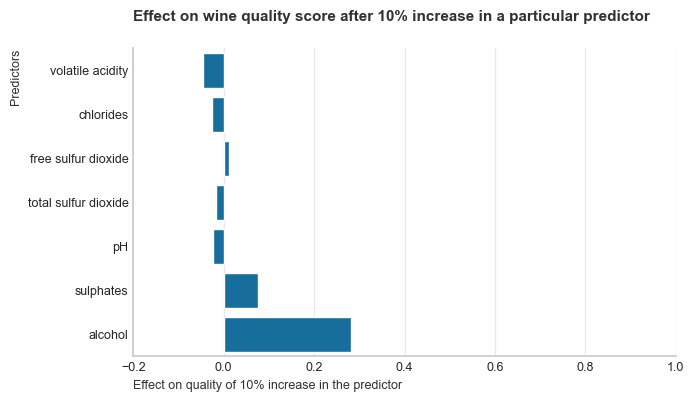

In [197]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(
    data=summary_effects,
    x="Effect on quality of 10% increase in the predictor",
    y="Predictors",
)
ax.set_title(
    "Effect on wine quality score after 10% increase in a particular predictor", pad=20
)
ax.set_xlim(-0.2, 1)
plt.show();

From the plot we see that alcohol has the greatest positive effect on wine quality score, sulphates positively impact wine quality more weakly. However, volatile acidity has the highest negative impact on perceived wine quality from other features.

#### **2.6. Checking Model on the Testing Data**

Now we will test our model performance on the test data. First, we must transform our test data accordingly before predicting wine quality scores.

In [201]:
cols = X_test.columns
X_test_transf_scaled = utils.transform_and_scale_predictors(
    cols, transform_funcs, X_test, scaler
)
X_test_transf_scaled_5 = X_test_transf_scaled.drop(
    ["fixed acidity", "density", "residual sugar", "citric acid"], axis=1
)
X_test_transf_scaled_5.head()

,volatile acidity,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol
1515,1.631322,-0.323553,0.294435,0.850188,1.314912,0.479191,-1.241639
1413,0.179690,0.689254,-0.117262,1.308184,-1.831886,1.406733,-0.299056
214,1.066798,0.324391,-0.378180,0.178582,-0.547478,0.421055,-0.622354
609,-0.949357,-0.283606,0.202075,0.105696,1.507573,-0.873493,2.156973
1597,0.582921,-0.283606,1.286387,0.281503,1.571793,0.421055,-0.193421


Now will add constant to the predictors matrix and get predictions. Since our predictions are continuous values, we will round them and plot residuals of our predictions.

In [203]:
X_test_transf_scaled_5_const = sm.add_constant(
    X_test_transf_scaled_5, has_constant="add"
)
y_pred_test = results5.predict(X_test_transf_scaled_5_const)
y_pred_test_cust = utils.customize_response(y_pred_test)
pd.Series(y_pred_test_cust).value_counts(normalize=True).map(
    lambda x: f"{x * 100:.1f}%"
)

6.0    53.4%
5.0    41.9%
7.0     4.7%
Name: proportion, dtype: object

We see that we have predictions only for the most dominant classes in our test dataset. Next we will plot distribution of residuals.

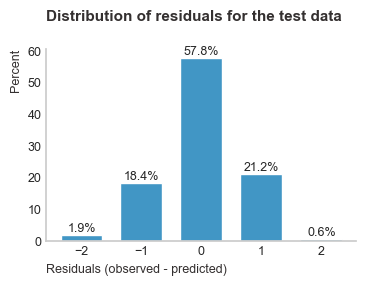

In [205]:
test_residuals = y_test["quality"] - y_pred_test_cust
utils.plot_residuals_dist(
    test_residuals, (4, 2.5), "Distribution of residuals for the test data"
)

From the plot above we see that ~60% of our test samples were correctly classified, ~40% we classified to the next lower or higher class then it should be. Neraly the same distribution of residuals is for the training data.

Further, let's examine how our error metrics changed as compared to predictions on the training data.

In [207]:
R_sq_adj_train = results5.rsquared_adj
train_metrics = [R_sq_adj_train, MAE5, RSE5]

comparison_metrics = utils.compare_train_test_metrics(
    X_test_transf_scaled_5, y_test, y_pred_test_cust, train_metrics
)
comparison_metrics

,Metrics,Train data,Test data,Difference in metric
0,R squared adjusted,0.358926,0.212701,0.146224
1,MAE,0.495480,0.446875,0.048605
2,RSE,0.647449,0.713874,-0.066424


After testing our model's performance on the test data we see that MAE is a little bit larger on the training data, but testing data has a larger RSE, which suggests that there are more larger errors made on predictions for the testing dataset. Adjusted R squared for test dataset is 21.3%, so this is 14.6% percentage points lower then for the training dataset (35.9%). So we see that our model explains only 21% of response variability on the unseen dataset.

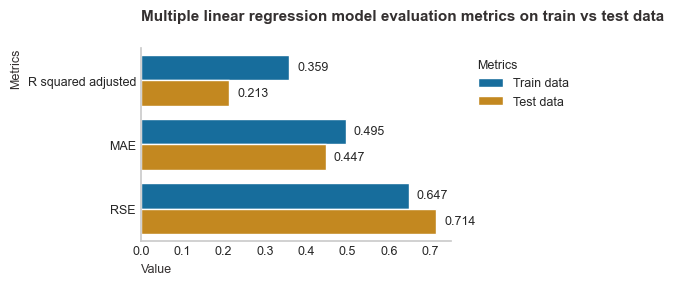

In [209]:
utils.plot_models_comparison_metrics(
    comparison_metrics, (4, 2.5), "Multiple linear regression model"
)

On the plot above we see that our model performs worse on the test data comparing with the training data, so we have encountered overfitting to the training data.

Since in reality our response variable is an ordinal not a continuous variable, we will try additionaly to model it with Ordinal Logistic Regression model. This model can help us classify wine into its quality category providing probabilities of being in a higher category.

### **3. Ordinal Logistic Regression Modelling**

Ordinal Logistic Regression model rests on several key assumptions that ensure valid estimation and inference:
* Ordinal dependent variable - the response variable must have ordered categories, which have a meaningful order but not equal spacing.   
-> Wine quality classes are indeed on the ordinal scale.

* Proportional odds assumption - the effect of each predictor (log-odds coefficient) is identical across all cumulative splits of the outcome categories. So there is one slope per predictor across all the levels of outcome variable. To say it simple, each input variable has a similar effect in the different levels of the ordinal outcome variable.   
-> In R package there is Brant-Wald test, but it is not available in any python library yet. We will try manually to test this assumption.

* Independence of observations - each case is independent and residuals are not correlated across observations.   
-> We checked this in linear regression assumptions section and this assumption is satisfied.

* No perfect multicollinearity - predictors are not exact linear combinations of one another. High multicollinearity can inflate standard errors of the coefficients, making it difficult to determine the independent effect of each predictor and can lead to unstable coefficient estimates.
-> We have calculated VIF, none of the predictors have VIF > 10.

* Linearity of log odds - each continuous predictor is assumed to have a constant additive effect on the logit (logarithm of the odds) of the outcome.   
-> CCPR plots or Box-Tidwell test are not available in Python for Ordered model yet, but we will try to manually check this assumption. 

* No extreme outliers in predictors -> we have found out that there are no anomalies in our dataset, just natural variation of physicochemical wine features.

##### **3.1. Fitting Ordinal Logistic Regression Model**

Let's change our response variable to its true type - categorical and fit the Orderder Logistic Regression Model.

In [216]:
y_train["quality"] = pd.Categorical(
    y_train["quality"], categories=[i for i in range(1, 11)], ordered=True
)
X_ord = X.iloc[:, 1:]
res1 = utils.make_ordinal_log_regr_model(y_train, X_ord)

Optimization terminated successfully.
         Current function value: 0.958298
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
McFadden's pseudo R-squared 0.1916
                             OrderedModel Results                             
Dep. Variable:                quality   Log-Likelihood:                -1225.7
Model:                   OrderedModel   AIC:                             2483.
Method:            Maximum Likelihood   BIC:                             2566.
Date:                Mon, 19 May 2025                                         
Time:                        11:49:45                                         
No. Observations:                1279                                         
Df Residuals:                    1263                                         
Df Model:                          11                                         
                           coef    std err          z      P>|z|      [0.025      

From the model results above we see that fixed acidity has the largest p-value (0.236), so we will drop this feature and fit the model again.

In [218]:
X_ord_minus_fixed = X_ord.drop("fixed acidity", axis=1)
res2 = utils.make_ordinal_log_regr_model(y_train, X_ord_minus_fixed)

Optimization terminated successfully.
         Current function value: 0.958849
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
McFadden's pseudo R-squared 0.1911
                             OrderedModel Results                             
Dep. Variable:                quality   Log-Likelihood:                -1226.4
Model:                   OrderedModel   AIC:                             2483.
Method:            Maximum Likelihood   BIC:                             2560.
Date:                Mon, 19 May 2025                                         
Time:                        11:49:45                                         
No. Observations:                1279                                         
Df Residuals:                    1264                                         
Df Model:                          10                                         
                           coef    std err          z      P>|z|      [0.025      

Now p-value of density increased to 0.56, so this is the next insignificant predictor to eliminate.

In [220]:
X_ord_minus_fixed_density = X_ord.drop(["fixed acidity", "density"], axis=1)
res3 = utils.make_ordinal_log_regr_model(y_train, X_ord_minus_fixed_density)

Optimization terminated successfully.
         Current function value: 0.958982
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
McFadden's pseudo R-squared 0.1910
                             OrderedModel Results                             
Dep. Variable:                quality   Log-Likelihood:                -1226.5
Model:                   OrderedModel   AIC:                             2481.
Method:            Maximum Likelihood   BIC:                             2553.
Date:                Mon, 19 May 2025                                         
Time:                        11:49:46                                         
No. Observations:                1279                                         
Df Residuals:                    1265                                         
Df Model:                           9                                         
                           coef    std err          z      P>|z|      [0.025      

Further let's eliminate residual sugar since its p-value (0.351) exceeds our 0.05 significance level.

In [222]:
X_ord_minus_fixed_density_sugar = X_ord.drop(
    ["fixed acidity", "density", "residual sugar"], axis=1
)
res4 = utils.make_ordinal_log_regr_model(y_train, X_ord_minus_fixed_density_sugar)

Optimization terminated successfully.
         Current function value: 0.959321
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
McFadden's pseudo R-squared 0.1907
                             OrderedModel Results                             
Dep. Variable:                quality   Log-Likelihood:                -1227.0
Model:                   OrderedModel   AIC:                             2480.
Method:            Maximum Likelihood   BIC:                             2547.
Date:                Mon, 19 May 2025                                         
Time:                        11:49:46                                         
No. Observations:                1279                                         
Df Residuals:                    1266                                         
Df Model:                           8                                         
                           coef    std err          z      P>|z|      [0.025      

Finally, let's eliminate citric acid (p-value 0.291) and make a model again.

In [224]:
X_ord_minus_fixed_density_sugar_citric = X_ord.drop(
    ["fixed acidity", "density", "residual sugar", "citric acid"], axis=1
)
res5 = utils.make_ordinal_log_regr_model(
    y_train, X_ord_minus_fixed_density_sugar_citric
)

Optimization terminated successfully.
         Current function value: 0.959757
         Iterations: 36
         Function evaluations: 38
         Gradient evaluations: 38
McFadden's pseudo R-squared 0.1903
                             OrderedModel Results                             
Dep. Variable:                quality   Log-Likelihood:                -1227.5
Model:                   OrderedModel   AIC:                             2479.
Method:            Maximum Likelihood   BIC:                             2541.
Date:                Mon, 19 May 2025                                         
Time:                        11:49:47                                         
No. Observations:                1279                                         
Df Residuals:                    1267                                         
Df Model:                           7                                         
                           coef    std err          z      P>|z|      [0.025      

McFadden's pseudo R squared is quite similar across all five ordinal models ~19%, indicating a moderate improvement in log-likelihood over the intercept-only model. This suggests that the included predictors explain a moderate proportion of the variability in our quality categories (very good fit is 0.2-0.4).

Considering coefficients for predictors - a positive coefficient shifts the cumulative probability curve to the right, making higher outcome classes more likely. 

Received coefficients are log of odds of being in a higher wine quality class. But since we took a logarithm of some predictors and scaled all of them for being able to interpret those coefficients, we must retransform and rescale them back.

In [226]:
coefs_ord = res5.params.iloc[:7]
changes_in_odds = []
odds_ratios = []
for std, coef, transf in zip(stds, coefs_ord, transformations):
    odds_ratio, perc_change = utils.rescale_to_odds(
        coef, std, 0.1, transf, none_transf_stats
    )
    changes_in_odds.append(perc_change)
    odds_ratios.append(odds_ratio)

Let's make a table that summarizes all the necessary information for coefficients' interpretation.

In [228]:
pd.DataFrame(
    {
        "Coefficient": coefs_ord,
        "Transformation": transformations,
        "Odds ratio": odds_ratios,
        "Effect on odds of 10% increase in the predictor": changes_in_odds,
    }
)

,Coefficient,Transformation,Odds ratio,Effect on odds of 10% increase in the predictor
volatile acidity,-0.460224,None,0.8724,-12.76
chlorides,-0.273075,Log,0.9230,-7.70
free sulfur dioxide,0.269801,Log,1.0385,3.85
total sulfur dioxide,-0.444393,Log,0.9421,-5.79
pH,-0.231518,None,0.9336,-6.64
sulphates,0.552698,Log,1.2719,27.19
alcohol,0.915968,Log,2.3896,138.96


For features that were not transformed we could say:
* **Volatile acidity** - 10% increase (relative to the mean) in volatile acidity reduces the odds of being in a higher wine quality category by ~13% if all other variables are constant.
* **pH** - 10% increase (relative to the mean) in pH reduces the odds of being in a higher wine quality category by ~7% if all other variables are constant.

For features that were log transformed we could interpret:
* **Chlorides** - 10% increase in chlorides reduces the odds of being in a higher wine quality category by ~8% if all other variables are constant.
* **Free sulfur dioxide** - 10% increase in free sulfur dioxide increases the odds of being in a higher wine quality category by ~4% if all other variables are constant.
* **Total sulfur dioxide** - 10% increase in total sulfur dioxide reduces the odds of being in a higher wine quality category by ~6% if all other variables are constant.
* **Sulphates** - 10% increase in sulphates increases the odds of being in a higher wine quality category by ~27% if all other variables are constant.
* **Alcohol** - 10% increase in alcohol increases the odds of being in a higher wine quality category by ~139% if all other variables are constant.

So to summarize perceived wine quality is mostly effected by alcohol, sulphates and volatile acidity.

Next we will compare AIC and BIC metrics for our Ordinal models.

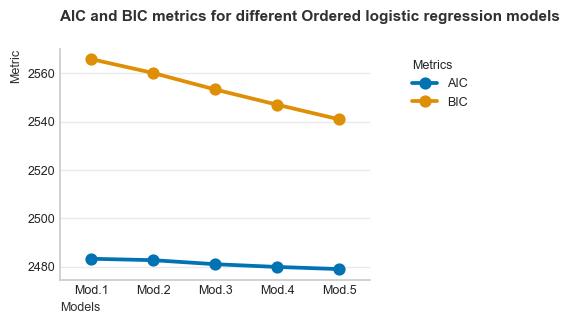

In [231]:
results_ord = [res1, res2, res3, res4, res5]
utils.compare_ordered_models(results_ord, (4, 3), "Ordered logistic regression")

Comparing all five Ordered Logistic Regression models using backward selection approach we see that BIC, which penalizes more for model complexity, decreases at a higher rate then AIC and those both metrics imply that our fifth model is the best from all five.

#### **3.2. Checking Ordinal Logistic Regression Model Assumptions**

**Checking Proportional Odds assumption**

This is one of the most crucial assumptions for Ordinal Model and it suggest that each predictor has a similar effect across different response variable category levels, so there is only one coefficient in the regression equation for each predictor.

Since Brant test is not available in Python, we will try to simulate this check manually. For each cut-off point we will fit separate binary Logistic regression model and check parameters for each predictor. Then plot those values and see if there are any evidences of curvature.

In [235]:
J = int(y_train.nunique())
X_brant = sm.add_constant(X_minus_citric_fixed_sugar_density)

In [236]:
coef_df = pd.DataFrame()
for j in range(1, (J - 1)):
    yj = (y_train["quality"] <= (j + 3)).astype(int).to_frame()
    m = sm.Logit(yj, X_brant).fit(method="bfgs", maxiter=800, disp=False)
    coef_df[f"<={j+3}"] = m.params
print(coef_df)

                           <=4       <=5       <=6       <=7
const                -3.798354 -0.245642  2.893389  6.149614
volatile acidity      0.618562  0.409783  0.497583 -0.027724
chlorides             0.100231  0.193133  0.420299  0.555868
free sulfur dioxide  -0.286348 -0.351364 -0.297464 -0.204034
total sulfur dioxide -0.219074  0.588397  0.695218  0.615126
pH                    0.478528  0.142974  0.284663  0.410764
sulphates            -0.277272 -0.523585 -0.707294 -0.816458
alcohol              -0.384817 -0.891016 -1.051123 -1.305743


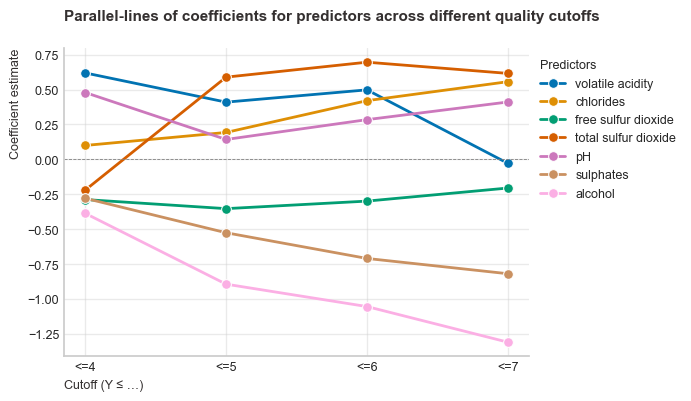

In [237]:
coefs_data = coef_df.T.iloc[:, 1:]
utils.plot_multi_lines(
    coefs_data,
    (6, 4),
    "Coefficient estimate",
    "Cutoff (Y ≤ …)",
    "Parallel-lines of coefficients for predictors across different quality cutoffs",
    "Predictors",
)

From the plot above we see that each predictor at each quality cutoff threshold has its own coefficient forming a curved line. There are no parallel lines which should be if assumption holds. This suggests that proportional odds assumption is violated.

**Linearity in the Log Odds assumtpion**

This is another important assumption that should be validated. This assumption states that each continuous predictor has a straight line relationship with the log-odds of the outcome. Hence, for any one unit increase in a predictor, the change in log(p/(1-p)) is constant across the range of the predictor. 

So we will take our most explanatory power having predictor *alcohol*, bin it into 10 bins, compute the empirical logit at each bin for each *quality* cutoff, and plot those log-odds against separate bin midpoints. Straight lines will indicate that assumptions holds, whereas curvature signals the need for nonlinear terms.

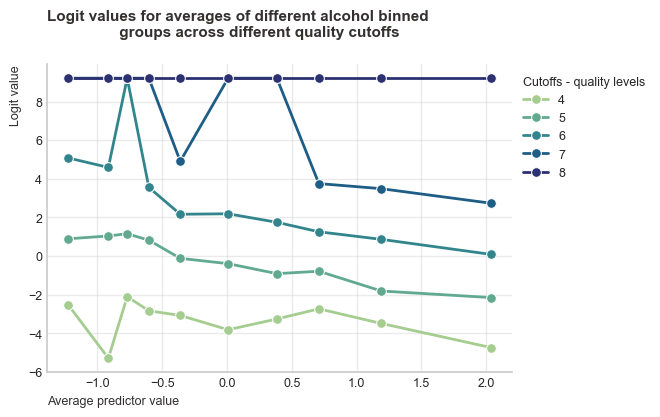

In [240]:
X_minus_citric_fixed_sugar_density["alcohol_bin"] = pd.qcut(
    X_minus_citric_fixed_sugar_density["alcohol"], q=10
)
df_linearity = pd.concat([X_minus_citric_fixed_sugar_density, y_train], axis=1)
logits = []
for key, group in df_linearity.groupby("alcohol_bin"):
    group_mean = group["alcohol"].mean()
    for j in range(1, J):
        p = (group["quality"] <= (j + 3)).mean()
        # avoid 0 or 1 because of division in odds ratio
        p = min(max(p, 1e-4), 1 - 1e-4)
        logits.append(
            {"cutoff": j + 3, "mid_alc": group_mean, "logit": np.log(p / (1 - p))}
        )
logit_df = pd.DataFrame(logits)

utils.plot_multi_lines(
    logit_df,
    (6, 4),
    "Logit value",
    "Average predictor value",
    """Logit values for averages of different alcohol binned 
                 groups across different quality cutoffs""",
    "Cutoffs - quality levels",
    "mid_alc",
    y="logit",
    hue="cutoff",
    palette="crest",
    hline=False,
)

As we see from the plot above for each cutoff value except <= 8, logit function or log-odds are curved lines suggesting non-linearity in log odds. Since all the samples fall into the category <= 8, log-odds are positive infinity. So from just our one predictor we can see that linearity assumption is violated.

**Key Insights**
* We have checked the most crucial Ordinal Logistic model assumptions - Proportional Odds and Linearity in Log-Odds - and found out that these both assumptions are violated.
* Violation of those assumptions means that single coefficient per predictor doesn't reflect a truly curved effect, so we have biased coefficients and misleading confidence intervals as well as incorrect p-values.
* Violated linearity assumption means that nonlinear terms of the predictors should be investigated.

#### **3.3. Checking Ordinal Model on the Test Data**

Let's check our model performance on the test data. Since in multiple regression modelling we have already eliminated the same four features, we have already prepared our testing dataset.

In [245]:
y_pred = utils.make_ordinal_predictions(res5, X_test_transf_scaled_5)
y_pred.value_counts()

6    152
5    150
7     18
Name: count, dtype: int64

We see that our Ordinal model grouped only to three most popular classes, ingnoring those with quite a few samples from classes 3, 4 and 8. This is the consequence of imbalanced dataset, where some groups are represented by a higher degree then others.

Now let's evaluate our model performance on the unseen data making confusion matrix and classfication report.

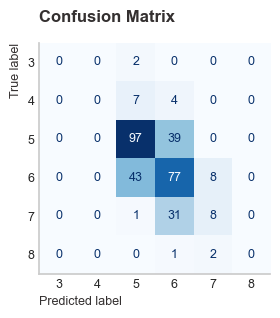

In [248]:
labels = [3, 4, 5, 6, 7, 8]
utils.make_and_customize_confusion_matrix(labels, y_test, y_pred, (4, 3))

From the confusion matrix we see that most popular predicted classes were 5th and 6th because of imbalanced data. There were no predictions for 3rd, 4th and 8th quality classes.

In [250]:
print(f"Accuracy score: {accuracy_score(y_test, y_pred):.3f}")
print(f"Balanced accuracy {balanced_accuracy_score(y_test, y_pred):.3f}")
print(
    "Classification report:\n", classification_report(y_test, y_pred, zero_division=0)
)

Accuracy score: 0.569
Balanced accuracy 0.252
Classification report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.65      0.71      0.68       136
           6       0.51      0.60      0.55       128
           7       0.44      0.20      0.28        40
           8       0.00      0.00      0.00         3

    accuracy                           0.57       320
   macro avg       0.27      0.25      0.25       320
weighted avg       0.53      0.57      0.54       320



**Accuracy** - overall proportion of correctly predicted labels. We got 57% of cases were correctly assigned to a certain quality class.

**Balanced Accuracy** - When classes are imbalanced, as in our case, average recall (sensitivity) per class. It means how many cases of a certain class level were correctly assigned to that class. We got 25%, what means that on average 25% of wines belonging to a given class were assigned to that class. 

**Precision** - of all predicted particular class cases how many actually belong to that class. We got the highest precision for 5 and 6 classes (were lay the majority of wine samples), respectively, 65% and 51%. For less popular wine quality levels the model wasn't as much precise (44% for class 7).

**Recall (Sensitivity)** - of all actual particular cases, how many were correctly predicted. We got the highest recall for 5 and 6 classes (were lay the majority of wine samples), respectively, 71% and 60%. For less popular wine quality levels the model wasn't as much sensitive (20% for class 7).    

**F1-score** - harmonic mean of precision and recall that balances both. We got the highest f1-score for 5 and 6 classes (were lay the majority of wine samples), respectively, 68% and 55%. For less popular wine quality the model wasn't as much precise (28% for class 7).   

In addition, let's check how residuals are distributed on the test data for the Ordered model.

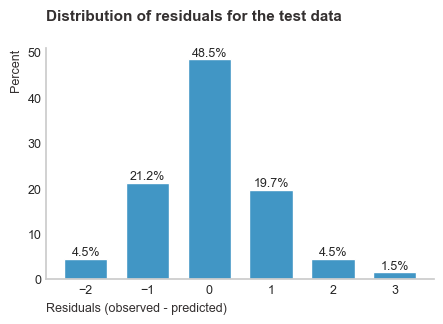

In [253]:
ord_residuals = y_test["quality"] - y_pred
utils.plot_residuals_dist(
    ord_residuals, (5, 3), "Distribution of residuals for the test data"
)

From the plot above we see that ~49% of the samples were correctly classified (in multiple linear regession model (MLRM) ~58%) and ~40% as for MLRM were misclassified to the nearest lower or higher class. Here we have 9% of the samples misclassified to the second nearest lower or higher class, but in MLRM there were ~2.5% such mistakes. For both models we got linearity assumption violated what suggests that we should further play around with nonlinear terms of predictors or even search for meaningful interaction terms to improve our model's explanatory power.

**Key Insights**:
* The Ordinal Logistic Regression Model filtered out the same statistically significant features as MLRM.
* The highest positive impact on wine quality is of alcohol and sulphates, negative - of volatile acidity.
* Our fitted Ordinal model has the overall accuracy of 57%.
* Because of imbalanced dataset Ordinal model best classifies samples for dominant quality classes (5th and 6th).
* Comparing with MLRM our model, Ordinal model made more errors misclassifying samples to the second nearest lower or higher quality classes.

### **Conclusions**

After performing both Multiple Linear and Ordered Logistic Regression models we can state:

* There were identified the same set of statistically significant features that have an impact on perceived wine quality using both Ordinal Logistic and Multiple Linear Regression Models.

* Multiple Linear Regression model failed for linearity, residuals' normality and homoskedasticity assumptions, causing our inference to be biased and not reliable.

* Ordered Logistic Regression Model also failed in linearity of log odds and proportional odds assumptions, what also makes our inference not reliable.

* Despite our models' bias, we can say that the largest positive impact on perceived wine quality have alcohol and sulphates. However, volatile acidity has the largest negative impact on perceived wine quality.

* Final Multiple Linear Regression model explains only about 36% of the total response variable variance.

* Accuracy of our final Ordered Logistic Regression model is ~57%. Pseudo R squared is 19%.

* Best OLR and MLR model performance is on most dominant 5th and 6th quality level classes because of high data imbalance.

* OLR model on the test data correctly identified 49% of the cases, ~40% were misclassified to the nearest lower or higher perceived quality class.

* MLR model on the test data correctly identified 59% of the cases, ~40% were misclassified to the nearest lower or higher perceived quality class.

* OLR model misclassified samples to the second nearest lower or higher perceived quality class for 9% samples, multiple linear regression - for 2.5% samples.

### **Suggestions for Improvement**

For explanatory purposes we sought for the simplest model for better interpretability, however, failing with assumptions for Ordinal and Multiple Linear Regression models make us conclude that further we should experiment including nonlinear terms of the predictors, search for meaningful interaction terms that could help us better capture nonlinearity in predictors-response relationship.